In [1]:
import os, glob, zipfile, sys
from pathlib import Path
!pip install flwr
import os
import socket
import time
import warnings
import logging
import threading
import multiprocessing as mp
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import flwr as fl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters

# --- Pick the zip you uploaded ---
CANDIDATES = [p for p in glob.glob("*.zip") if os.path.isfile(p)]
if not CANDIDATES:
    raise SystemExit("No .zip files found in the current directory.")
# Prefer a file named 'reduced_data.zip', else take the largest .zip
ZIP = "reduced_data.zip" if "reduced_data.zip" in CANDIDATES else max(CANDIDATES, key=os.path.getsize)
OUT = Path(os.path.splitext(ZIP)[0])
print(f"Using ZIP: {ZIP}")

# --- Quick diagnostics (size + magic bytes) ---
size_bytes = os.path.getsize(ZIP)
size_mb = size_bytes / (1024**2)
print(f"Size: {size_mb:.2f} MB")

with open(ZIP, "rb") as f:
    magic = f.read(4)

print("Magic bytes:", magic)  # Expected b'PK\x03\x04' for a normal ZIP entry

# If the file is clearly too small, stop with a helpful message
EXPECTED_MIN_MB = 300  # reduced_data.zip ~317 MB (roughly)
if size_mb < EXPECTED_MIN_MB:
    # show the start of the file in case it's an HTML error saved as .zip
    with open(ZIP, "rb") as f:
        head = f.read(200)
    try:
        head_txt = head.decode("utf-8", errors="replace")
    except:
        head_txt = str(head)
    print("\n--- File header preview (first 200 bytes) ---")
    print(head_txt)
    raise SystemExit(
        f"\n'{ZIP}' looks truncated ({size_mb:.2f} MB). "
        f"Please re-upload the full reduced_data.zip (~317 MB) and try again."
    )

# --- Validate the ZIP before extracting ---
if not zipfile.is_zipfile(ZIP):
    raise SystemExit(f"'{ZIP}' is not a valid ZIP (is_zipfile=False). Re-upload the correct file.")

with zipfile.ZipFile(ZIP, 'r') as zf:
    bad = zf.testzip()
    if bad:
        raise SystemExit(f"Archive is corrupted. First bad member: {bad}. Re-upload the file.")
    OUT.mkdir(parents=True, exist_ok=True)
    zf.extractall(OUT)

print(f"\nExtracted successfully to: {OUT.resolve()}")
print("Top-level contents:")
for name in sorted(os.listdir(OUT))[:50]:
    print(" ", name)


Using ZIP: reduced_data.zip
Size: 305.47 MB
Magic bytes: b'PK\x03\x04'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Extracted successfully to: /content/reduced_data
Top-level contents:
  reduced_data


In [2]:
from pathlib import Path
import pandas as pd

# Find the real root (some zips contain an extra top-level folder)
root = Path("reduced_data")
if (root / "reduced_data").exists():
    root = root / "reduced_data"

print("Data root:", root.resolve())
print("Resolutions found:", [p.name for p in root.iterdir() if p.is_dir()])

# --- Loaders (fast + low memory) ---
def load_weather(freq="1min"):
    fp = root / freq / "weather.csv.gz"
    return pd.read_csv(fp, compression="gzip",
                       parse_dates=["datetime_utc"],
                       dtype={"Igm":"float32","Ta":"float32"})

def load_electricity_P(freq="1min"):
    fp = root / freq / "electricity_P.csv.gz"
    return pd.read_csv(fp, compression="gzip",
                       parse_dates=["datetime_utc"],
                       dtype={"total":"float32","PV":"float32","CHP":"float32"})

# Example: read 1-minute data
df_wx  = load_weather("1min")
df_pwr = load_electricity_P("1min")

print(df_wx.head(), df_wx.shape)
print(df_pwr.head(), df_pwr.shape)

# (Optional) daily sanity check
daily = df_pwr.set_index("datetime_utc").sort_index()[["total","PV","CHP"]].resample("D").mean()
daily.head()


Data root: /content/reduced_data/reduced_data
Resolutions found: ['1h', '15min', '1min']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


         datetime_utc  WeatherStation.Weather.Igm  WeatherStation.Weather.Ta
0 2017-12-30 23:12:00                         NaN                  11.147052
1 2017-12-30 23:13:00                         NaN                  11.155257
2 2017-12-30 23:14:00                         NaN                  11.130801
3 2017-12-30 23:15:00                         NaN                  11.101900
4 2017-12-30 23:16:00                         NaN                  11.070782 (3156467, 3)
         datetime_utc          total  PV          CHP
0 2017-12-31 23:00:00  140001.375000 NaN  2623.770020
1 2017-12-31 23:01:00  189122.078125 NaN  2631.939941
2 2017-12-31 23:02:00  208486.125000 NaN  2618.149902
3 2017-12-31 23:03:00  206396.062500 NaN  2619.120117
4 2017-12-31 23:04:00  226908.562500 NaN  2636.379883 (3155039, 4)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,total,PV,CHP
datetime_utc,,,
2017-12-31,49724.476562,NaN,-141611.515625
2018-01-01,23445.080078,NaN,-168016.437500
2018-01-02,64172.503906,NaN,-155463.812500
2018-01-03,258393.468750,NaN,-18944.886719
2018-01-04,211185.750000,NaN,-50692.648438


In [3]:
# =========================
# Imports & configuration
# =========================
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import os, json

# Root where you extracted the reduced bundle (you printed this earlier)
ROOT = Path("reduced_data/reduced_data")

# Run for all three granularities
FREQS = ["1min", "15min", "1h"]

SEED = 42
np.random.seed(SEED)

# Where to save processed artifacts
OUTDIR = Path("prepared")
OUTDIR.mkdir(exist_ok=True, parents=True)

# =========================
# Load helpers (dtype-safe)
# =========================
def load_weather(root: Path, freq: str) -> pd.DataFrame:
    fp = root/freq/"weather.csv.gz"
    df = pd.read_csv(
        fp, compression="gzip", parse_dates=["datetime_utc"],
        dtype={"WeatherStation.Weather.Igm":"float32", "WeatherStation.Weather.Ta":"float32"}
    )
    df = df.rename(columns={
        "WeatherStation.Weather.Igm":"Igm",
        "WeatherStation.Weather.Ta":"Ta",
    })
    df = df.sort_values("datetime_utc").drop_duplicates(subset=["datetime_utc"])
    df = df.set_index("datetime_utc")
    return df

def load_electricityP(root: Path, freq: str) -> pd.DataFrame:
    fp = root/freq/"electricity_P.csv.gz"
    df = pd.read_csv(
        fp, compression="gzip", parse_dates=["datetime_utc"],
        dtype={"total":"float32","PV":"float32","CHP":"float32"}
    )
    df = df.sort_values("datetime_utc").drop_duplicates(subset=["datetime_utc"])
    df = df.set_index("datetime_utc")
    return df

# =========================
# Merge + NaN policy
# =========================
def preprocess_merge_to_frame(root: Path, freq: str) -> pd.DataFrame:
    elec = load_electricityP(root, freq)
    wx   = load_weather(root, freq)

    # outer join + regularize index to exact grid of the stated sampling
    df = elec.join(wx, how="outer").sort_index()
    step = {"1min":"1T","15min":"15T","1h":"1H"}[freq]
    full_index = pd.date_range(df.index.min(), df.index.max(), freq=step)
    df = df.reindex(full_index)

    # daylight heuristic
    hours = df.index.hour
    is_day = ((hours >= 6) & (hours < 18)) | (df["Igm"] > 5)
    df["is_day"] = is_day.astype("int8")

    # PV handling: 0 at night, keep day values then ffill/bfill tiny gaps
    pv = df["PV"].copy()
    pv[~is_day] = pv[~is_day].fillna(0.0)
    df["PV"] = pv

    # Igm handling: 0 at night, then ffill/bfill small gaps
    igm = df["Igm"].copy()
    igm[~is_day] = igm[~is_day].fillna(0.0)
    df["Igm"] = igm

    # short-gap smoothing for continuous sensors
    for col in ["total","PV","CHP","Igm","Ta"]:
        if col in df:
            df[col] = df[col].astype("float32").ffill(limit=4).bfill(limit=4)

    return df

# =========================
#  Aggregate to hourly + target T+1
# =========================
def to_hourly(df: pd.DataFrame) -> pd.DataFrame:
    agg = {
        "total":"mean", "PV":"mean", "CHP":"mean",
        "Igm":"mean", "Ta":"mean", "is_day":"max"
    }
    h = df.resample("1H").agg(agg)
    h.columns = [f"{c}_h" if c!="is_day" else "is_day" for c in h.columns]
    h["y_next_total_h"] = h["total_h"].shift(-1)   # next-hour target
    return h

# =========================
# Feature engineering
# =========================
def add_time_encodings(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.index
    hod = idx.hour.values
    dow = idx.dayofweek.values
    df["hod_sin"] = np.sin(2*np.pi*hod/24).astype("float32")
    df["hod_cos"] = np.cos(2*np.pi*hod/24).astype("float32")
    df["dow_sin"] = np.sin(2*np.pi*dow/7).astype("float32")
    df["dow_cos"] = np.cos(2*np.pi*dow/7).astype("float32")
    df["is_weekend"] = (dow >= 5).astype("int8")
    return df

def add_lags_and_rolls(df: pd.DataFrame) -> pd.DataFrame:
    base = ["total_h","PV_h","CHP_h","Igm_h","Ta_h"]
    for L in tqdm([1,2,3,6,12,24], desc="Building lags (hours)"):
        for c in base:
            df[f"{c}_lag{L}"] = df[c].shift(L).astype("float32")

    for w, tag in tqdm([(3,"3h"), (6,"6h"), (24,"24h")], desc="Rolling windows"):
        for c in base:
            df[f"{c}_mean_{tag}"] = df[c].rolling(w, min_periods=1).mean().astype("float32")
            df[f"{c}_std_{tag}"]  = df[c].rolling(w, min_periods=1).std().fillna(0).astype("float32")
    return df

# =========================
# Build ML table (chronological, clean)
# =========================
def build_ml_table(root: Path, freq: str) -> pd.DataFrame:
    df0 = preprocess_merge_to_frame(root, freq)
    dfh = to_hourly(df0)
    dfh = add_time_encodings(dfh)
    dfh = add_lags_and_rolls(dfh)

    # drop rows lacking target or recent lags
    keep = dfh.dropna(subset=["y_next_total_h"])
    reqs = ["total_h","PV_h","CHP_h","Igm_h","Ta_h"]
    for L in [1,2,3,6,12,24]:
        reqs += [f"{c}_lag{L}" for c in ["total_h","PV_h","Igm_h","Ta_h"]]
    keep = keep.dropna(subset=list(set(reqs)))

    # enforce float32 where applicable
    for col in keep.columns:
        if keep[col].dtype == "float64":
            keep[col] = keep[col].astype("float32")

    return keep.sort_index()

def chrono_split(df: pd.DataFrame, train=0.7, val=0.15):
    n = len(df)
    i_tr = int(n*train)
    i_va = int(n*(train+val))
    return df.iloc[:i_tr].copy(), df.iloc[i_tr:i_va].copy(), df.iloc[i_va:].copy()

# =========================
# Sequences for LSTM/Transformer
# =========================
def to_sequences(df: pd.DataFrame, features, target, lookback=24):
    X, y = [], []
    vals = df[features + [target]].values.astype("float32")
    for i in tqdm(range(lookback, len(df)), desc="Making sequences"):
        X.append(vals[i-lookback:i, :-1])
        y.append(vals[i, -1])
    return np.stack(X), np.array(y)

# =========================
# Run for all three frequencies
# =========================
import numpy as np

LOOKBACK = 24
RESULTS = {}

for freq in FREQS:
    print(f"\n=== Processing {freq} ===")
    ml = build_ml_table(ROOT, freq)
    print("Rows after FE:", len(ml), "| span:", ml.index.min(), "→", ml.index.max())
    FEATURES = [c for c in ml.columns if c != "y_next_total_h"]
    TARGET   = "y_next_total_h"

    tr, va, te = chrono_split(ml, train=0.7, val=0.15)
    X_tr, y_tr = to_sequences(tr, FEATURES, TARGET, LOOKBACK)
    X_va, y_va = to_sequences(va, FEATURES, TARGET, LOOKBACK)
    X_te, y_te = to_sequences(te, FEATURES, TARGET, LOOKBACK)

    # Save artifacts to disk (per-frequency)
    freq_out = OUTDIR/freq
    freq_out.mkdir(exist_ok=True, parents=True)
    ml.to_parquet(freq_out/"hourly_table.parquet", index=True)
    np.save(freq_out/"X_train.npy", X_tr); np.save(freq_out/"y_train.npy", y_tr)
    np.save(freq_out/"X_val.npy",   X_va); np.save(freq_out/"y_val.npy",   y_va)
    np.save(freq_out/"X_test.npy",  X_te); np.save(freq_out/"y_test.npy",  y_te)

    RESULTS[freq] = {
        "n_rows": len(ml),
        "n_features": len(FEATURES),
        "train_shape": X_tr.shape, "val_shape": X_va.shape, "test_shape": X_te.shape,
        "start": str(ml.index.min()), "end": str(ml.index.max())
    }

# Small summary
import pprint; pprint.pprint(RESULTS)



=== Processing 1min ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2818167837.py:60: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(df.index.min(), df.index.max(), freq=step)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2818167837.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = df.resam

Building lags (hours):   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rolling windows:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rows after FE: 38989 | span: 2018-01-02 05:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/27268 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/5824 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/5825 [00:00<?, ?it/s]


=== Processing 15min ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2818167837.py:60: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(df.index.min(), df.index.max(), freq=step)
/tmp/ipython-input-2818167837.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = df.resample("1H").agg(agg)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().r

Building lags (hours):   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rolling windows:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rows after FE: 39166 | span: 2018-01-02 05:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/27392 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/5851 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/5851 [00:00<?, ?it/s]


=== Processing 1h ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2818167837.py:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(df.index.min(), df.index.max(), freq=step)
/tmp/ipython-input-2818167837.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = df.resampl

Building lags (hours):   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rolling windows:   0%|          | 0/3 [00:00<?, ?it/s]

Rows after FE: 42506 | span: 2018-01-01 20:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/29730 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/6352 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Making sequences:   0%|          | 0/6352 [00:00<?, ?it/s]

{'15min': {'end': '2023-12-31 21:00:00',
           'n_features': 71,
           'n_rows': 39166,
           'start': '2018-01-02 05:00:00',
           'test_shape': (5851, 24, 71),
           'train_shape': (27392, 24, 71),
           'val_shape': (5851, 24, 71)},
 '1h': {'end': '2023-12-31 21:00:00',
        'n_features': 71,
        'n_rows': 42506,
        'start': '2018-01-01 20:00:00',
        'test_shape': (6352, 24, 71),
        'train_shape': (29730, 24, 71),
        'val_shape': (6352, 24, 71)},
 '1min': {'end': '2023-12-31 21:00:00',
          'n_features': 71,
          'n_rows': 38989,
          'start': '2018-01-02 05:00:00',
          'test_shape': (5825, 24, 71),
          'train_shape': (27268, 24, 71),
          'val_shape': (5824, 24, 71)}}


In [4]:
# --- PATCH: replace the old plot_autocorr with a robust, version-safe one ---
import numpy as np
import matplotlib.pyplot as plt

def plot_autocorr(df, outdir, title_suffix, max_lag=168):
    """
    Robust autocorrelation plot for df['total_h'] up to max_lag hours.
    - Drops NaNs
    - Handles zero-variance windows
    - Uses plt.stem WITHOUT deprecated args
    """
    x = df["total_h"].to_numpy(dtype=float)
    x = x[~np.isnan(x)]
    if x.size < 3:
        print("Not enough data for autocorr plot.")
        return

    # demean
    x = x - x.mean()

    ac = [1.0]
    for k in range(1, max_lag + 1):
        if k >= len(x) - 1:
            ac.append(np.nan)
            continue
        a = x[:-k]
        b = x[k:]
        sa = a.std(ddof=0)
        sb = b.std(ddof=0)
        if sa == 0 or sb == 0 or np.isnan(sa) or np.isnan(sb):
            ac.append(0.0)
        else:
            ac.append(float(((a - a.mean()) * (b - b.mean())).mean() / (sa * sb)))

    lags = np.arange(0, max_lag + 1)

    plt.figure(figsize=(8, 3))
    markerline, stemlines, baseline = plt.stem(lags, ac)
    # tidy baseline
    try:
        baseline.set_visible(False)
    except Exception:
        pass
    plt.title(f"Autocorrelation of Load (0..{max_lag}h) — {title_suffix}")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Correlation")
    plt.ylim(-0.2, 1.05)
    plt.tight_layout()
    plt.savefig(outdir / "autocorr_total_h.png", dpi=160)
    plt.close()


in] rows: 38989 | span: 2018-01-02 05:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


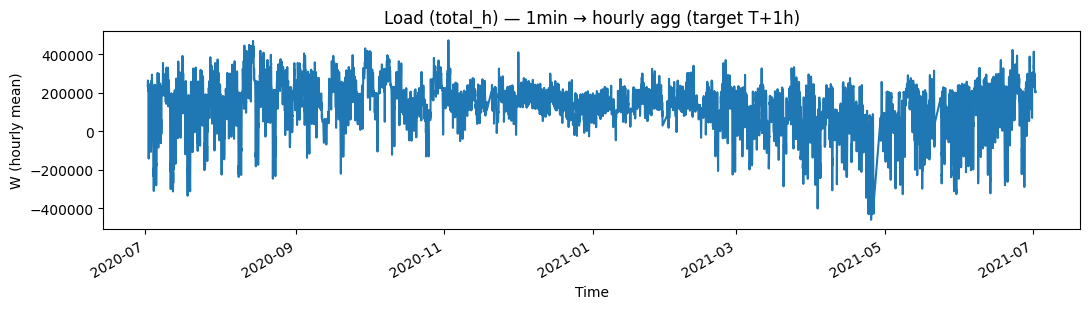

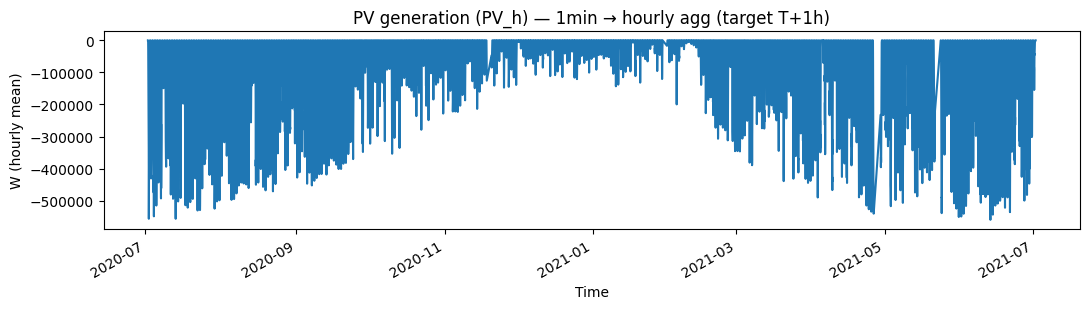

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


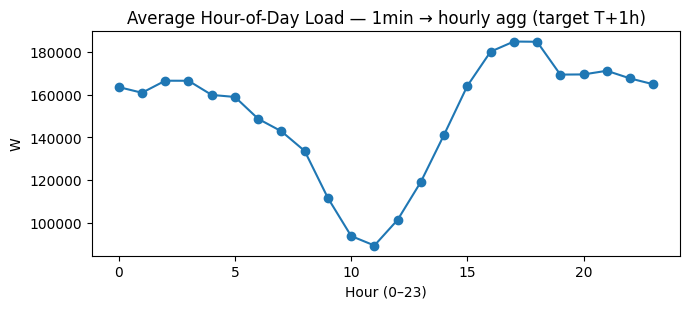

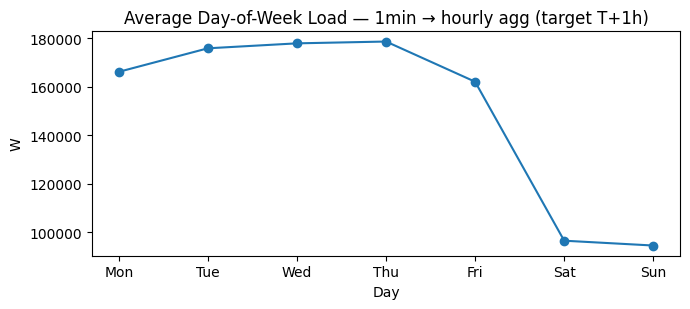

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


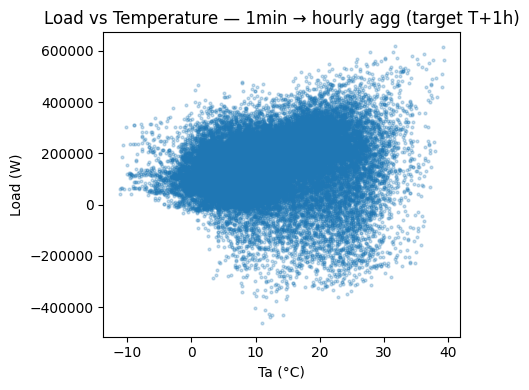

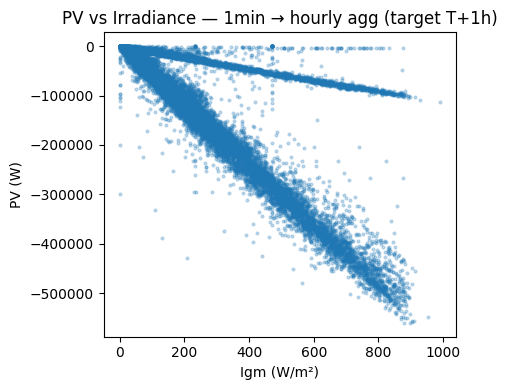

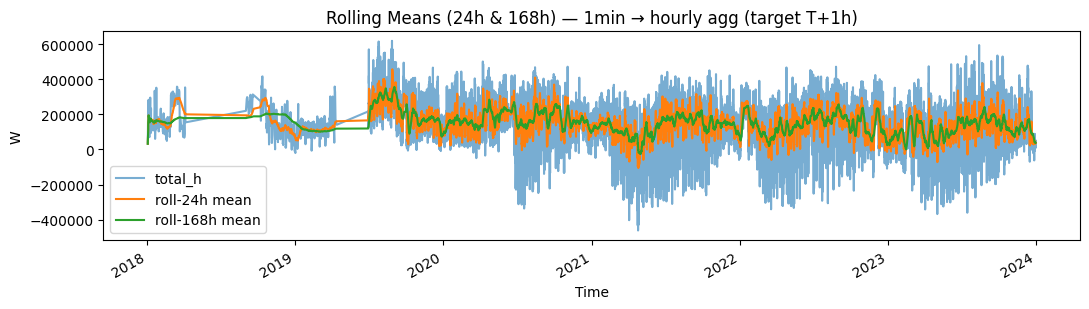

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


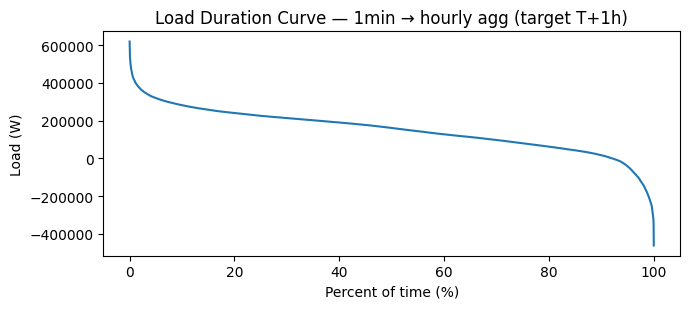

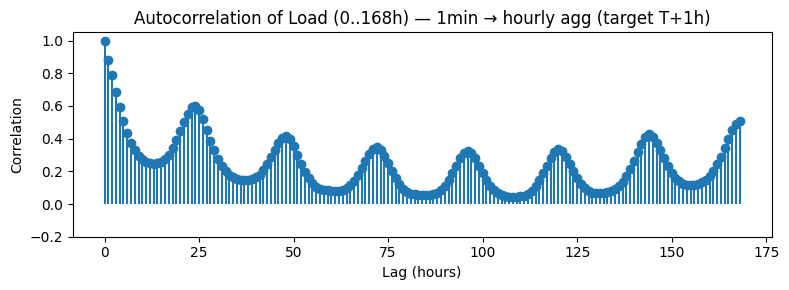

/tmp/ipython-input-738277695.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wkday, wkend], labels=["Weekday","Weekend"], showfliers=False)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


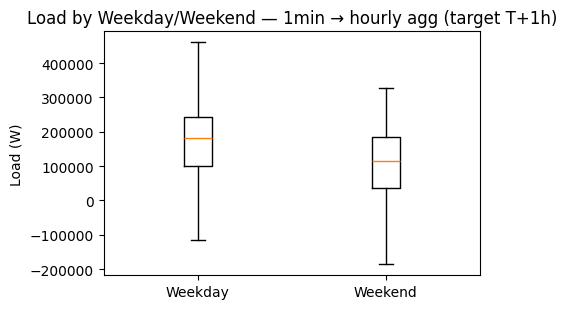

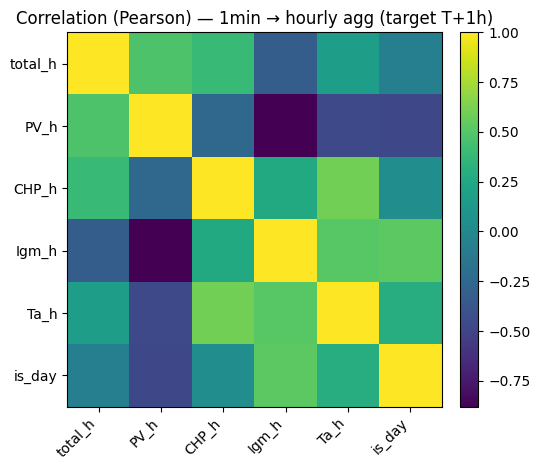

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


in] rows: 39166 | span: 2018-01-02 05:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


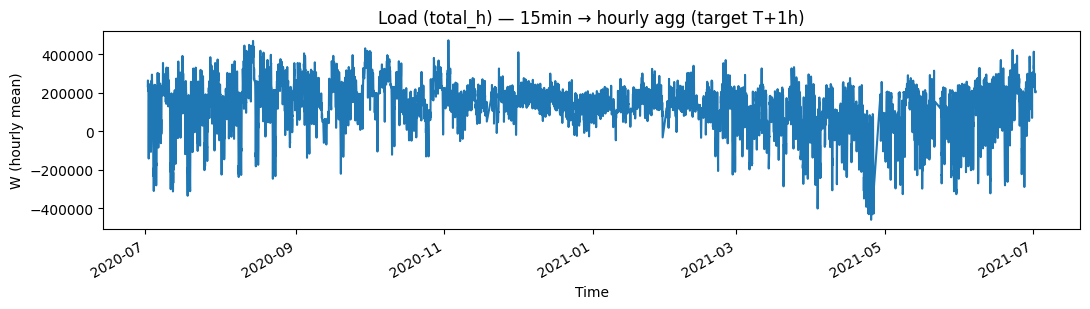

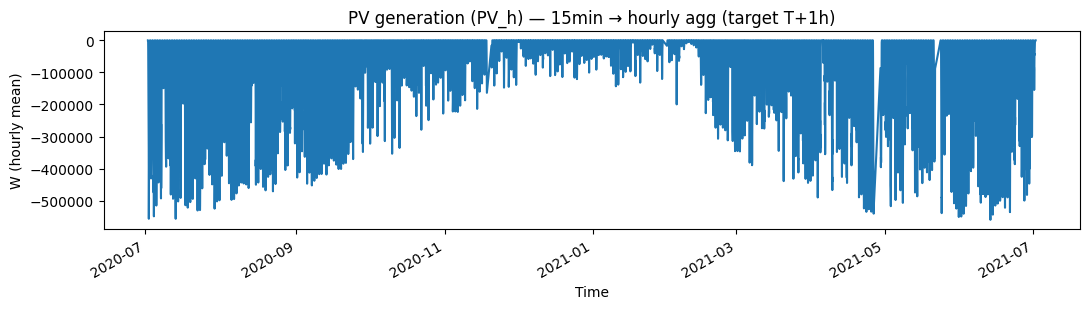

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


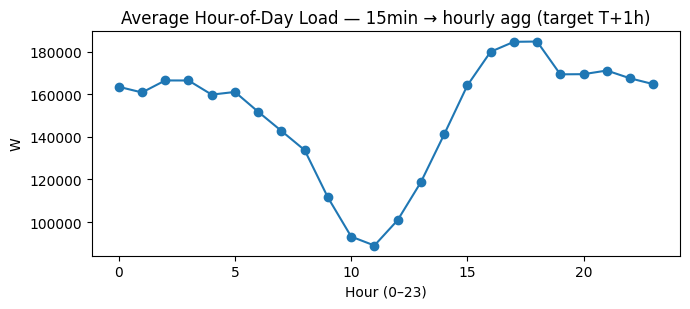

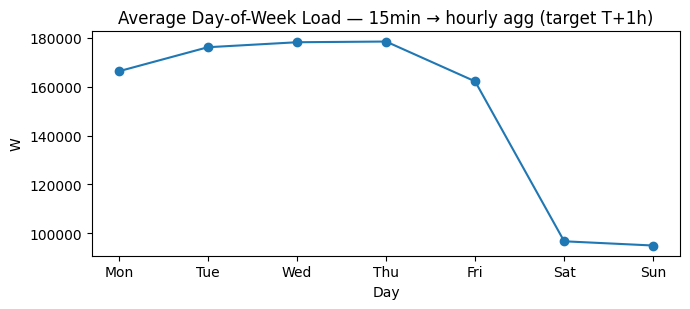

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


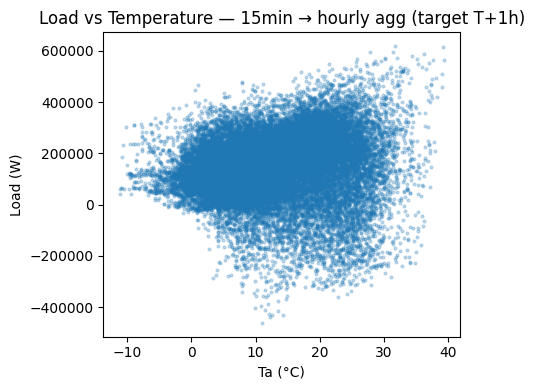

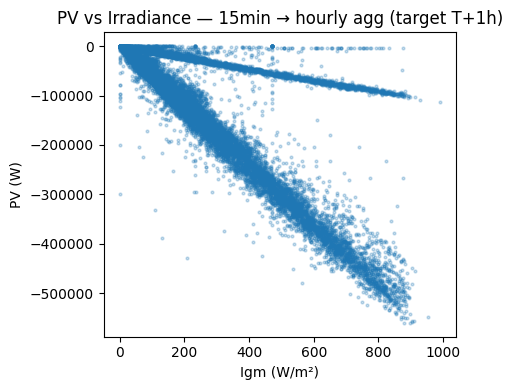

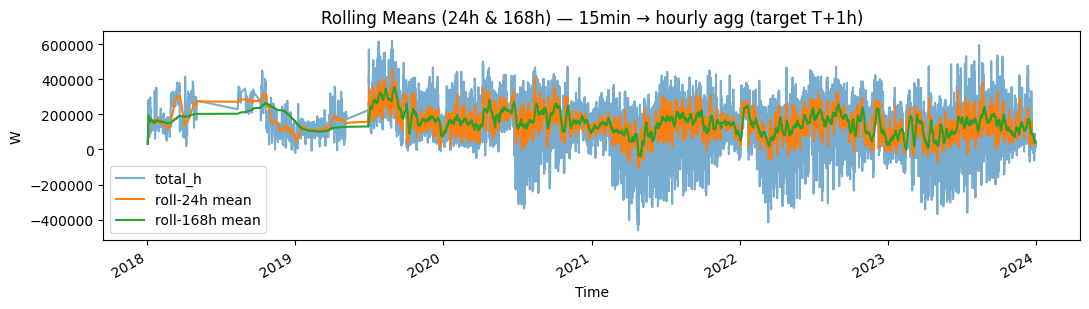

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


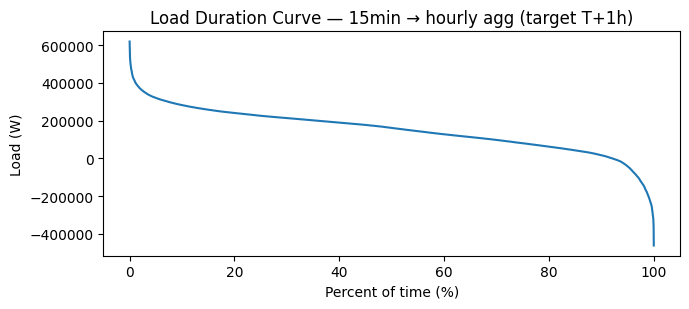

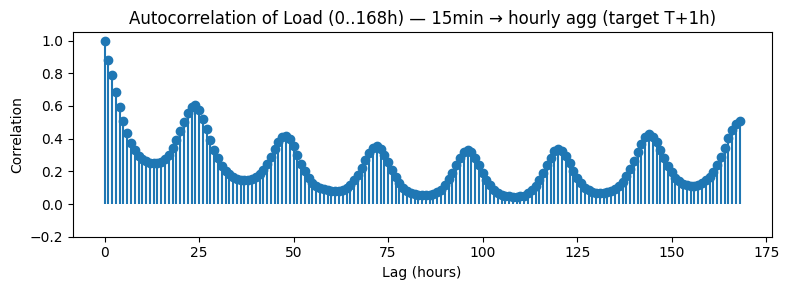

/tmp/ipython-input-738277695.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wkday, wkend], labels=["Weekday","Weekend"], showfliers=False)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


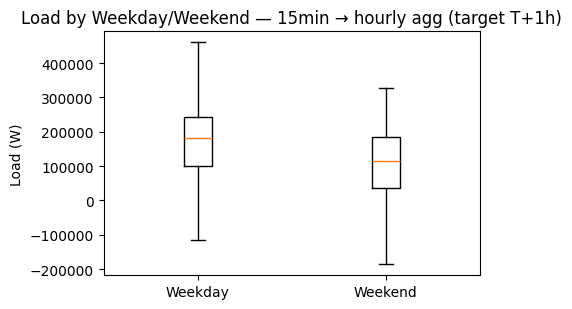

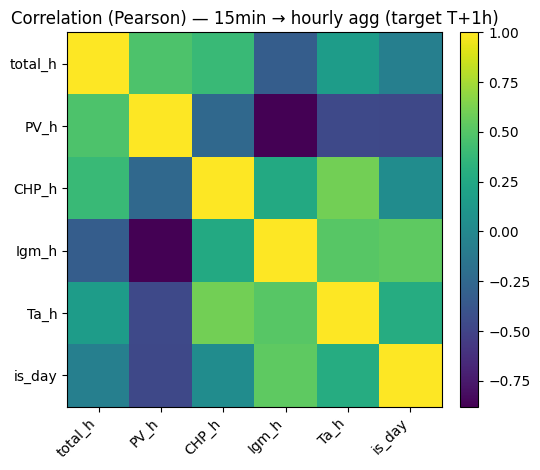

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[1h] rows: 42506 | span: 2018-01-01 20:00:00 → 2023-12-31 21:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


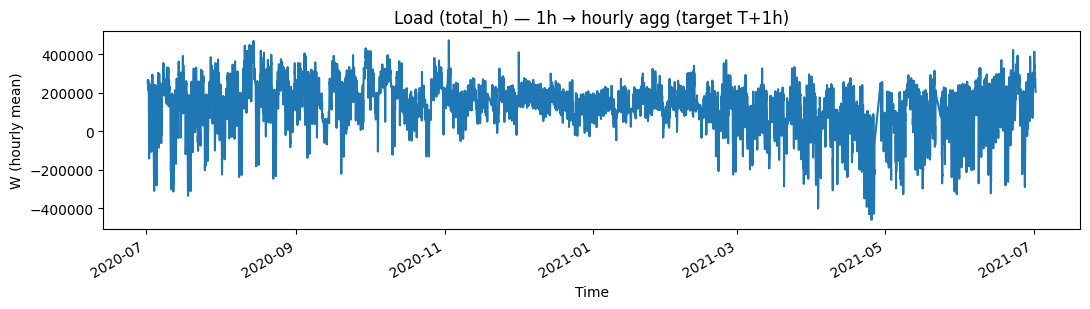

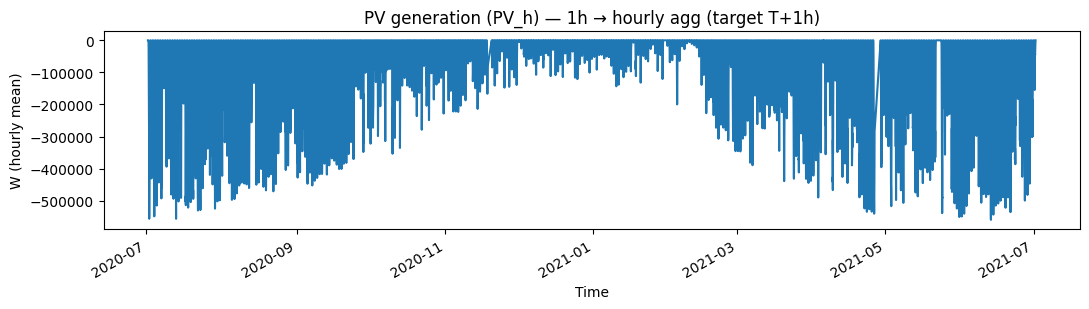

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


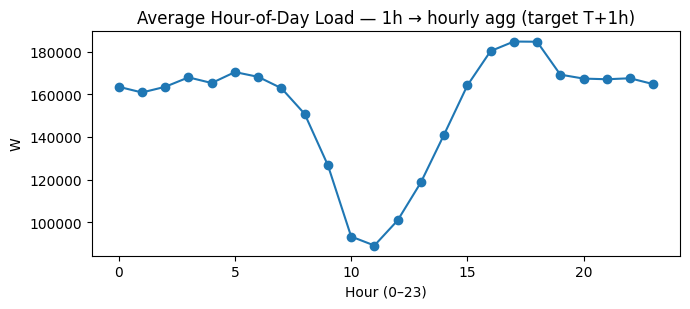

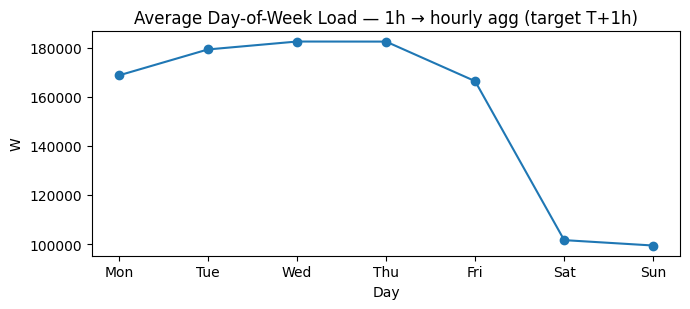

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


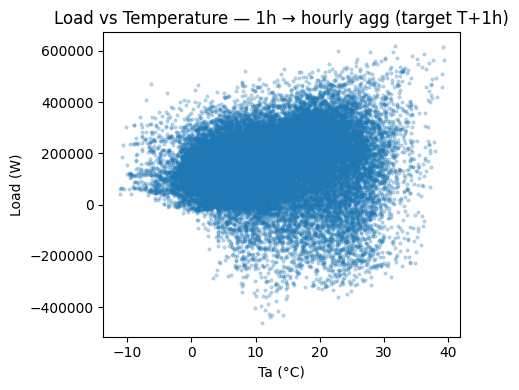

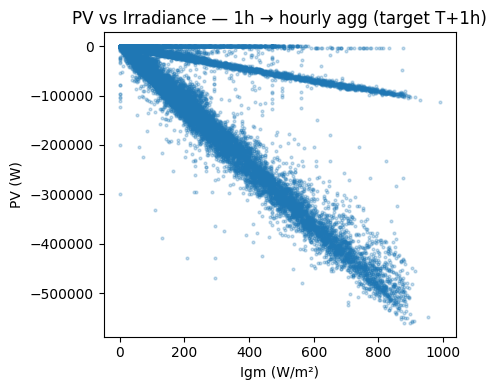

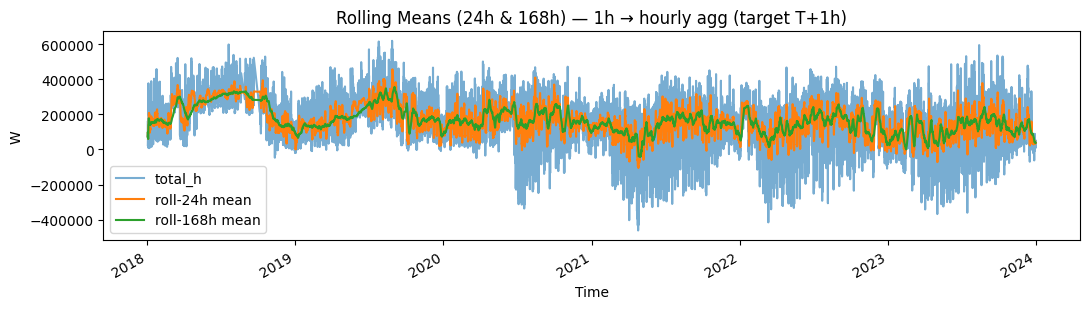

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


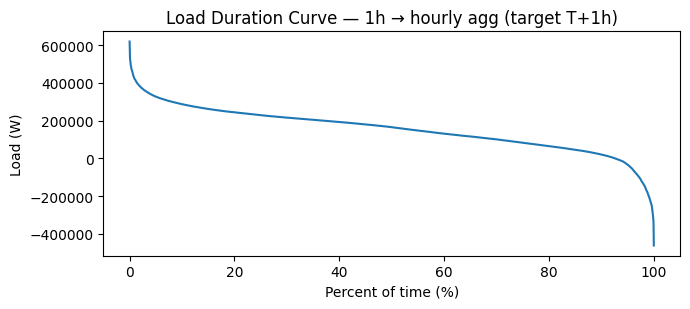

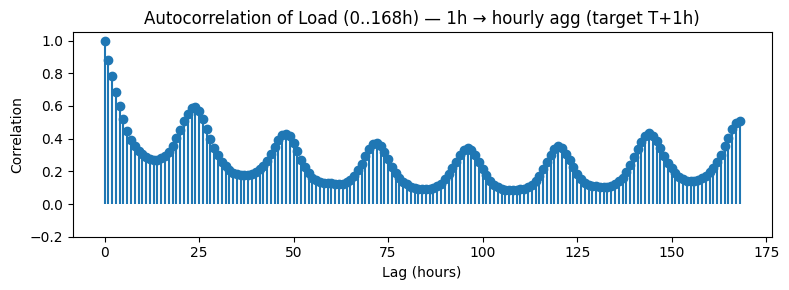

/tmp/ipython-input-738277695.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wkday, wkend], labels=["Weekday","Weekend"], showfliers=False)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


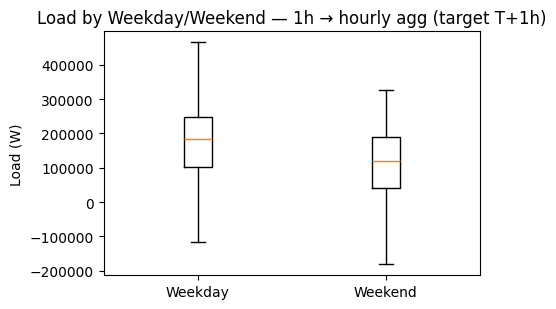

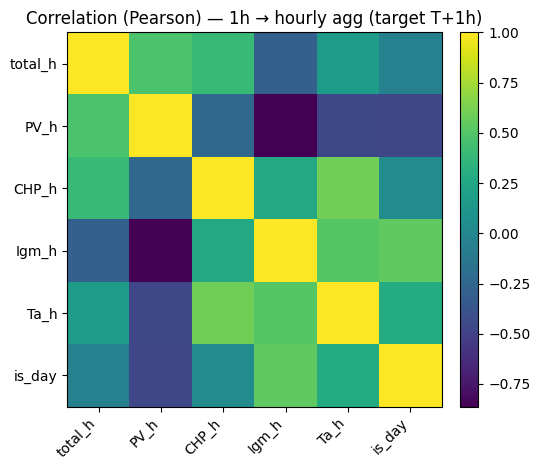

EDA images saved under: /content/eda


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
# =========================
# EDA for 1min, 15min, 1h (save + display)
# =========================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I/O
FREQS   = ["1min", "15min", "1h"]
INROOT  = Path("prepared")   # produced earlier
OUTROOT = Path("eda"); OUTROOT.mkdir(exist_ok=True, parents=True)
SHOW    = True               # <- display figures inline

# ---------- Data loader ----------
def load_hourly_table(freq: str) -> pd.DataFrame:
    fp = INROOT / freq / "hourly_table.parquet"
    df = pd.read_parquet(fp)
    df.index = pd.to_datetime(df.index)
    return df.sort_index()

# ---------- Helper to save & show ----------
def _save_and_show(outpath: Path, show: bool = SHOW, dpi: int = 160):
    plt.tight_layout()
    plt.savefig(outpath, dpi=dpi)
    if show:
        plt.show()
    plt.close()

# ---------- Plot helpers ----------
def plot_timeseries_sample(df: pd.DataFrame, outdir: Path, title_suffix: str):
    start, end = df.index.min(), df.index.max()
    if (end - start).days > 365:
        mid = start + (end - start)/2
        s = mid - pd.Timedelta(days=183)
        e = s + pd.Timedelta(days=365)
        d = df.loc[s:e]
    else:
        d = df

    plt.figure(figsize=(11,3.2))
    d["total_h"].plot()
    plt.title(f"Load (total_h) — {title_suffix}")
    plt.ylabel("W (hourly mean)"); plt.xlabel("Time")
    _save_and_show(outdir/"timeseries_total_h.png")

    plt.figure(figsize=(11,3.2))
    d["PV_h"].plot()
    plt.title(f"PV generation (PV_h) — {title_suffix}")
    plt.ylabel("W (hourly mean)"); plt.xlabel("Time")
    _save_and_show(outdir/"timeseries_PV_h.png")

def plot_profiles(df: pd.DataFrame, outdir: Path, title_suffix: str):
    hod = df.groupby(df.index.hour)["total_h"].mean()
    plt.figure(figsize=(7,3.2))
    hod.plot(marker="o")
    plt.title(f"Average Hour-of-Day Load — {title_suffix}")
    plt.xlabel("Hour (0–23)"); plt.ylabel("W")
    _save_and_show(outdir/"profile_hour_of_day.png")

    dow = df.groupby(df.index.dayofweek)["total_h"].mean()
    dow.index = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    plt.figure(figsize=(7,3.2))
    dow.plot(marker="o")
    plt.title(f"Average Day-of-Week Load — {title_suffix}")
    plt.xlabel("Day"); plt.ylabel("W")
    _save_and_show(outdir/"profile_day_of_week.png")

def plot_weather_drivers(df: pd.DataFrame, outdir: Path, title_suffix: str):
    plt.figure(figsize=(4.8,4))
    plt.scatter(df["Ta_h"], df["total_h"], s=4, alpha=0.25)
    plt.title(f"Load vs Temperature — {title_suffix}")
    plt.xlabel("Ta (°C)"); plt.ylabel("Load (W)")
    _save_and_show(outdir/"scatter_total_vs_Ta.png")

    plt.figure(figsize=(4.8,4))
    plt.scatter(df["Igm_h"], df["PV_h"], s=4, alpha=0.25)
    plt.title(f"PV vs Irradiance — {title_suffix}")
    plt.xlabel("Igm (W/m²)"); plt.ylabel("PV (W)")
    _save_and_show(outdir/"scatter_PV_vs_Igm.png")

def plot_rolling_and_ldc(df: pd.DataFrame, outdir: Path, title_suffix: str):
    r24  = df["total_h"].rolling(24, min_periods=1).mean()
    r168 = df["total_h"].rolling(168, min_periods=1).mean()

    plt.figure(figsize=(11,3.2))
    df["total_h"].plot(alpha=0.6)
    r24.plot(); r168.plot()
    plt.legend(["total_h","roll-24h mean","roll-168h mean"])
    plt.title(f"Rolling Means (24h & 168h) — {title_suffix}")
    plt.ylabel("W"); plt.xlabel("Time")
    _save_and_show(outdir/"rolling_means.png")

    sorted_load = np.sort(df["total_h"].values)[::-1]
    x = np.arange(1, len(sorted_load)+1)/len(sorted_load)*100.0
    plt.figure(figsize=(7,3.2))
    plt.plot(x, sorted_load)
    plt.title(f"Load Duration Curve — {title_suffix}")
    plt.xlabel("Percent of time (%)"); plt.ylabel("Load (W)")
    _save_and_show(outdir/"load_duration_curve.png")

def plot_autocorr(df: pd.DataFrame, outdir: Path, title_suffix: str, max_lag=168):
    x = df["total_h"].to_numpy(dtype=float)
    x = x[~np.isnan(x)]
    if x.size < 3:
        print("Not enough data for autocorr plot."); return
    x = x - x.mean()

    ac = [1.0]
    for k in range(1, max_lag + 1):
        if k >= len(x) - 1:
            ac.append(np.nan); continue
        a = x[:-k]; b = x[k:]
        sa, sb = a.std(ddof=0), b.std(ddof=0)
        if sa == 0 or sb == 0 or np.isnan(sa) or np.isnan(sb):
            ac.append(0.0)
        else:
            ac.append(float(((a - a.mean()) * (b - b.mean())).mean() / (sa * sb)))

    lags = np.arange(0, max_lag + 1)
    plt.figure(figsize=(8,3))
    markerline, stemlines, baseline = plt.stem(lags, ac)  # version-safe
    try: baseline.set_visible(False)
    except Exception: pass
    plt.title(f"Autocorrelation of Load (0..{max_lag}h) — {title_suffix}")
    plt.xlabel("Lag (hours)"); plt.ylabel("Correlation")
    plt.ylim(-0.2, 1.05)
    _save_and_show(outdir/"autocorr_total_h.png")

def plot_weekend_box(df: pd.DataFrame, outdir: Path, title_suffix: str):
    wkday = df[df["is_weekend"]==0]["total_h"].dropna().values
    wkend = df[df["is_weekend"]==1]["total_h"].dropna().values
    plt.figure(figsize=(5,3.2))
    plt.boxplot([wkday, wkend], labels=["Weekday","Weekend"], showfliers=False)
    plt.title(f"Load by Weekday/Weekend — {title_suffix}")
    plt.ylabel("Load (W)")
    _save_and_show(outdir/"box_weekday_vs_weekend.png")

def plot_corr_matrix(df: pd.DataFrame, outdir: Path, title_suffix: str):
    keep = ["total_h","PV_h","CHP_h","Igm_h","Ta_h","is_day"]
    sub = df[keep].copy()
    C = sub.corr(numeric_only=True).values
    labels = keep

    plt.figure(figsize=(5.6,4.8))
    im = plt.imshow(C, interpolation="nearest")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(f"Correlation (Pearson) — {title_suffix}")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    _save_and_show(outdir/"corr_matrix.png")

# ---------- Run EDA for all three ----------
for freq in FREQS:
    df = load_hourly_table(freq)
    cols = ["total_h","PV_h","CHP_h","Igm_h","Ta_h","is_day","is_weekend"]
    df = df[cols].dropna(subset=["total_h"]).copy()

    od = OUTROOT / freq
    od.mkdir(parents=True, exist_ok=True)

    title = f"{freq} → hourly agg (target T+1h)"
    print(f"[{freq}] rows: {len(df)} | span: {df.index.min()} → {df.index.max()}")

    plot_timeseries_sample(df, od, title)
    plot_profiles(df, od, title)
    plot_weather_drivers(df, od, title)
    plot_rolling_and_ldc(df, od, title)
    plot_autocorr(df, od, title, max_lag=168)
    plot_weekend_box(df, od, title)
    plot_corr_matrix(df, od, title)

print("EDA images saved under:", OUTROOT.resolve())


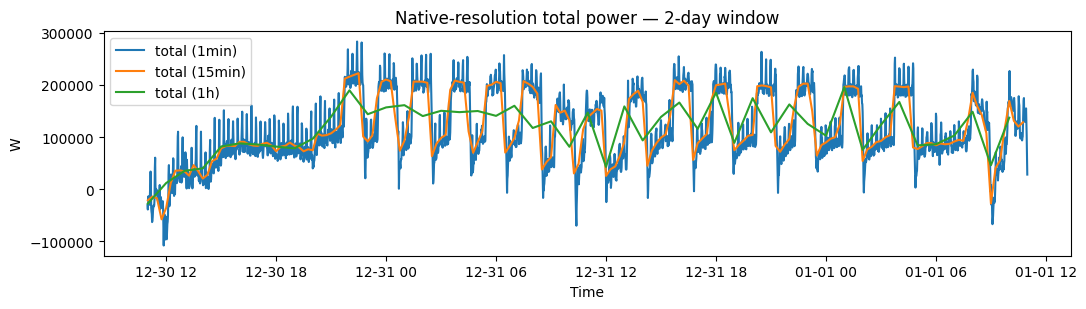

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


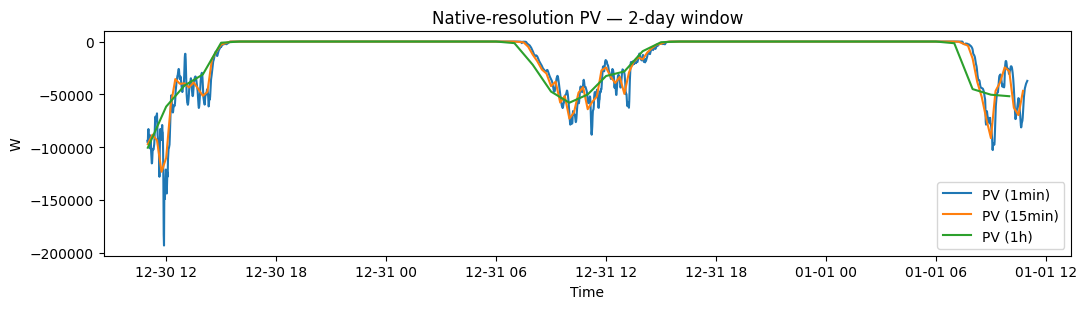

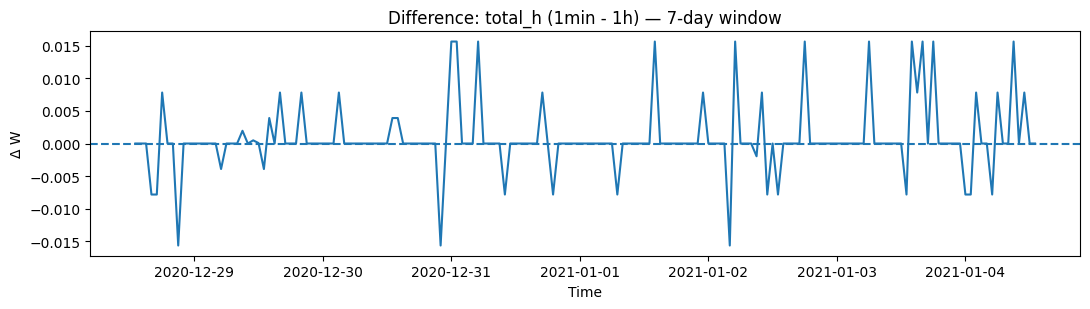

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


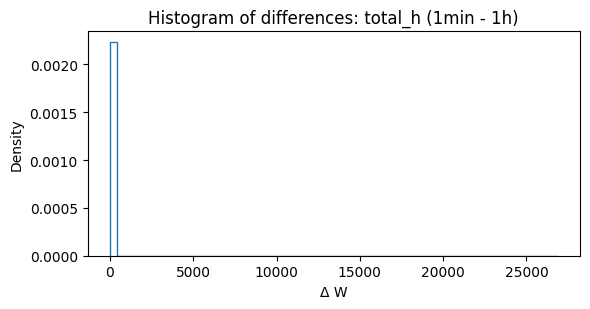

total_h: 1min - 1h | mean=0.6943, MAE=0.6978, RMSE=136.0797, n=38989


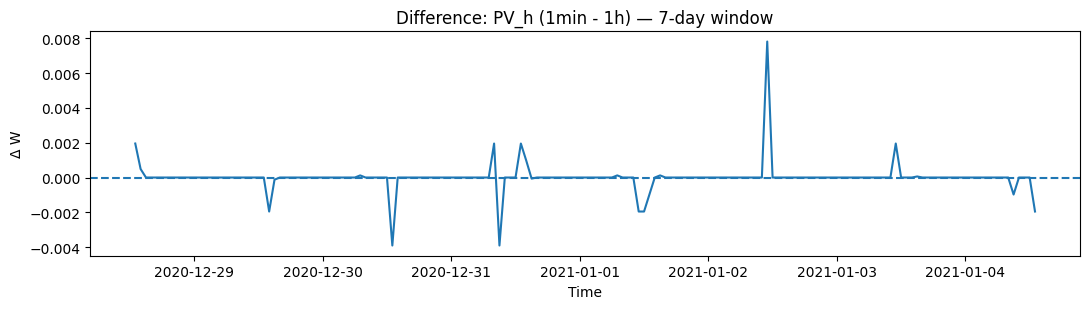

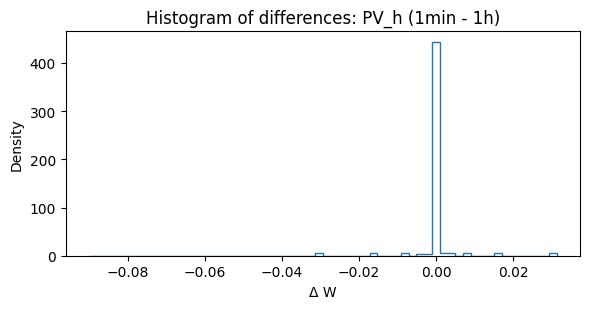

PV_h: 1min - 1h | mean=-0.0000, MAE=0.0013, RMSE=0.0054, n=38989


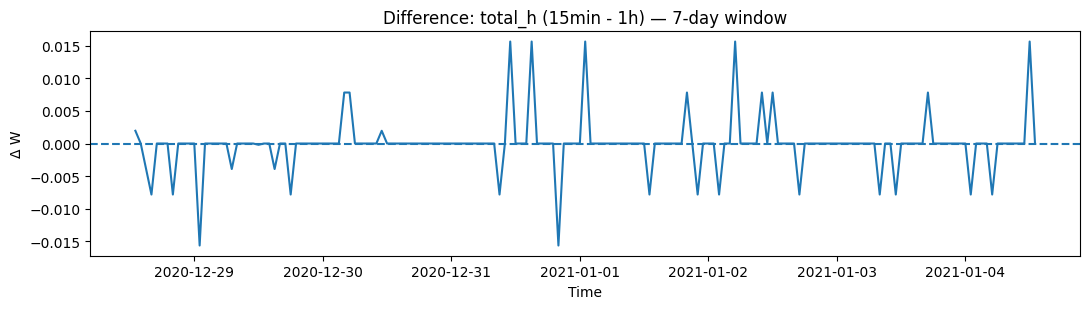

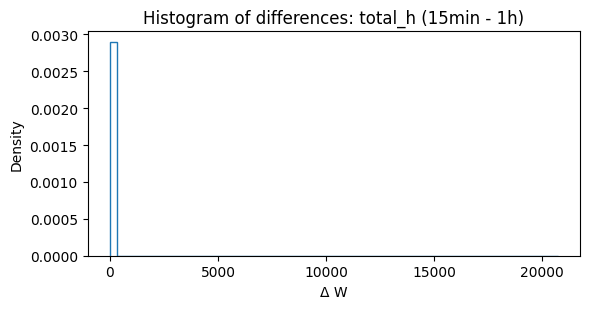

total_h: 15min - 1h | mean=0.5505, MAE=0.5526, RMSE=104.9755, n=38989


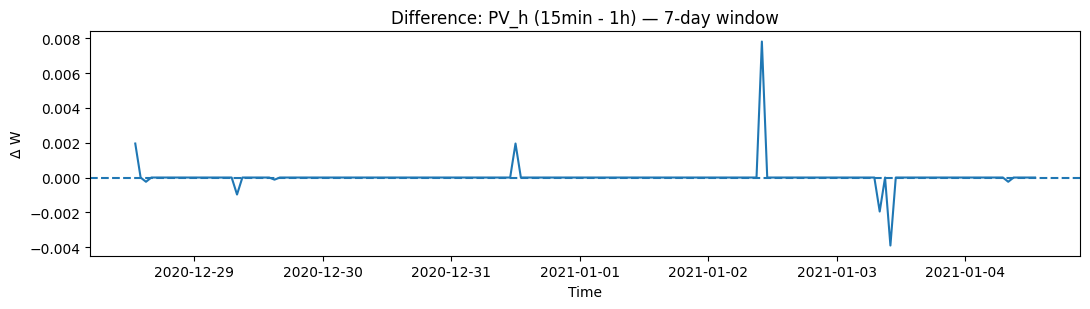

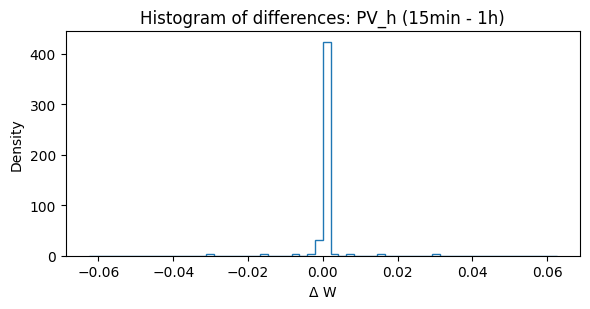

PV_h: 15min - 1h | mean=-0.0000, MAE=0.0008, RMSE=0.0041, n=38989
Saved figures to: /content/eda_compare_native


In [6]:
# ============================================
# Cross-compare at native resolution + hourly differences
# ============================================
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
RAWROOT = Path("reduced_data/reduced_data")  # raw reduced bundle you extracted
PREPROOT = Path("prepared")                  # hourly engineered tables
OUTROOT = Path("eda_compare_native"); OUTROOT.mkdir(parents=True, exist_ok=True)
SHOW = True

# ---------- helpers ----------
def _save_and_show(path: Path, show: bool = SHOW, dpi: int = 160):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    if show: plt.show()
    plt.close()

def load_raw_total(freq: str) -> pd.DataFrame:
    """
    Load raw electricity power (W) at native resolution.
    Returns a DataFrame with columns: total, PV, CHP
    """
    fp = RAWROOT / freq / "electricity_P.csv.gz"
    df = pd.read_csv(fp, compression="gzip",
                     parse_dates=["datetime_utc"],
                     dtype={"total":"float32","PV":"float32","CHP":"float32"})
    df = df.sort_values("datetime_utc").drop_duplicates(subset=["datetime_utc"])
    df = df.set_index("datetime_utc")
    return df

def pick_window(df: pd.DataFrame, days=2):
    start, end = df.index.min(), df.index.max()
    if (end - start).days <= days:
        return df
    mid = start + (end - start)/2
    s = mid - pd.Timedelta(days=days/2)
    e = s + pd.Timedelta(days=days)
    return df.loc[s:e]

def load_hourly_table(freq: str) -> pd.DataFrame:
    fp = PREPROOT / freq / "hourly_table.parquet"
    df = pd.read_parquet(fp)
    df.index = pd.to_datetime(df.index)
    return df.sort_index()

def normalize_hourly_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_convert(None)
    df.index = pd.to_datetime(df.index).floor("h")  # lower-case 'h'
    if df.index.has_duplicates:
        df = df.groupby(df.index).first()
    return df.sort_index()

# ---------- Native-resolution overlay (raw) ----------
# Load raw total (W) at each native freq
raw_1min = load_raw_total("1min")
raw_15m  = load_raw_total("15min")
raw_1h   = load_raw_total("1h")

# Choose a 2-day window to visualize
DAYS = 2
w1 = pick_window(raw_1min[["total"]], days=DAYS)
w2 = raw_15m.loc[w1.index.min():w1.index.max(), ["total"]]
w3 = raw_1h.loc[w1.index.min():w1.index.max(), ["total"]]

plt.figure(figsize=(11,3.2))
plt.plot(w1.index, w1["total"], label="total (1min)")
plt.plot(w2.index, w2["total"], label="total (15min)")
plt.plot(w3.index, w3["total"], label="total (1h)")
plt.legend()
plt.title(f"Native-resolution total power — {DAYS}-day window")
plt.ylabel("W"); plt.xlabel("Time")
_save_and_show(OUTROOT/"native_overlay_total.png")

# Optional: PV as well
pv1 = pick_window(raw_1min[["PV"]], days=DAYS)
pv2 = raw_15m.loc[pv1.index.min():pv1.index.max(), ["PV"]]
pv3 = raw_1h.loc[pv1.index.min():pv1.index.max(), ["PV"]]

plt.figure(figsize=(11,3.2))
plt.plot(pv1.index, pv1["PV"], label="PV (1min)")
plt.plot(pv2.index, pv2["PV"], label="PV (15min)")
plt.plot(pv3.index, pv3["PV"], label="PV (1h)")
plt.legend()
plt.title(f"Native-resolution PV — {DAYS}-day window")
plt.ylabel("W"); plt.xlabel("Time")
_save_and_show(OUTROOT/"native_overlay_pv.png")

# ---------- Hourly difference analysis ----------
# Load engineered hourly tables and align strictly
def align_hourly(core=("total_h","PV_h","CHP_h","Igm_h","Ta_h")):
    frames = []
    freqs = ["1min","15min","1h"]
    for f in freqs:
        df = load_hourly_table(f)
        keep = [c for c in core if c in df.columns]
        sub = df.loc[:, keep]
        sub = normalize_hourly_index(sub)
        sub.columns = [f"{c}_{f}" for c in keep]
        frames.append(sub)
    combo = pd.concat(frames, axis=1, join="inner").sort_index()
    return combo

combo = align_hourly()

# Differences against 1h (should be ~0 if hourly aggregates match exactly)
pairs = [("1min","1h"), ("15min","1h")]
for a, b in pairs:
    for var in ["total_h","PV_h"]:
        diff = combo[f"{var}_{a}"] - combo[f"{var}_{b}"]
        # 7-day window for visibility
        W = pick_window(diff.to_frame("diff"), days=7)["diff"]
        plt.figure(figsize=(11,3.2))
        plt.plot(W.index, W.values)
        plt.axhline(0, linestyle="--")
        plt.title(f"Difference: {var} ({a} - {b}) — 7-day window")
        plt.ylabel("Δ W"); plt.xlabel("Time")
        _save_and_show(OUTROOT/f"diff_{var}_{a}_minus_{b}.png")

        # Histogram of differences
        vals = diff.dropna().values
        plt.figure(figsize=(6,3.2))
        plt.hist(vals, bins=60, histtype="step", density=True)
        plt.title(f"Histogram of differences: {var} ({a} - {b})")
        plt.xlabel("Δ W"); plt.ylabel("Density")
        _save_and_show(OUTROOT/f"hist_diff_{var}_{a}_minus_{b}.png")

        # Print summary stats
        if len(vals):
            mae  = float(np.mean(np.abs(vals)))
            rmse = float(np.sqrt(np.mean(vals**2)))
            mean = float(np.mean(vals))
            print(f"{var}: {a} - {b} | mean={mean:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, n={len(vals)}")

print("Saved figures to:", OUTROOT.resolve())


In [7]:
# ============================================================
# Federated-ready feature extraction & training data packaging
# - loads engineered hourly tables from prepared/<freq>/
# - fits scaler on TRAIN only, transforms X
# - builds sliding windows (LOOKBACK=24) for T+1 load forecast
# - saves X/y splits + scaler params under fl_ready/<freq>/<client>/
# - provides PyTorch Dataset & DataLoader builders
# ============================================================

import json, os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# ---------------- Config ----------------
FREQS = ["1min", "15min", "1h"]
CLIENTS = {"CAMPUS": "."}   # for reduced bundle (single client). For full data, map client_id -> path
LOOKBACK = 24               # hours of history -> next-hour target
TRAIN_SPLIT, VAL_SPLIT = 0.70, 0.15
SEED = 42
np.random.seed(SEED)

INROOT  = Path("prepared")
OUTROOT = Path("fl_ready"); OUTROOT.mkdir(parents=True, exist_ok=True)

# ---------------- Helpers ----------------
def load_hourly_table(freq: str) -> pd.DataFrame:
    df = pd.read_parquet(INROOT/freq/"hourly_table.parquet")
    df.index = pd.to_datetime(df.index)
    return df.sort_index()

def chrono_split(df: pd.DataFrame, train=TRAIN_SPLIT, val=VAL_SPLIT):
    n = len(df)
    i_tr = int(n*train)
    i_va = int(n*(train+val))
    return df.iloc[:i_tr].copy(), df.iloc[i_tr:i_va].copy(), df.iloc[i_va:].copy()

def fit_transform_scaler(train_df: pd.DataFrame, full_df: pd.DataFrame, feature_cols):
    """
    Fit StandardScaler on TRAIN only; return transformed full_df and scaler params.
    """
    Xtr = train_df[feature_cols].to_numpy(dtype=np.float32)
    mean = Xtr.mean(axis=0)
    std  = Xtr.std(axis=0)
    std[std==0] = 1.0  # avoid divide-by-zero
    Xfull = (full_df[feature_cols].to_numpy(dtype=np.float32) - mean) / std
    scaled = full_df.copy()
    scaled[feature_cols] = Xfull
    scaler = {"feature_names": list(feature_cols),
              "mean": mean.tolist(), "std": std.tolist()}
    return scaled, scaler

def to_sequences(df: pd.DataFrame, features, target, lookback=LOOKBACK):
    X, y = [], []
    vals = df[features + [target]].to_numpy(dtype=np.float32)
    for i in tqdm(range(lookback, len(df)), desc=f"Seq({lookback})"):
        X.append(vals[i-lookback:i, :-1])
        y.append(vals[i, -1])
    if len(X)==0:
        return np.empty((0, lookback, len(features)), dtype=np.float32), np.empty((0,), dtype=np.float32)
    return np.stack(X), np.array(y, dtype=np.float32)

def save_json(path: Path, obj):
    path.write_text(json.dumps(obj, indent=2))

# ---------------- PyTorch dataset/loader (optional, ready-to-train) ----------------
try:
    import torch
    from torch.utils.data import Dataset, DataLoader

    class SequenceDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.from_numpy(X)  # (N, T, F)
            self.y = torch.from_numpy(y).unsqueeze(-1)  # (N, 1)
        def __len__(self): return self.X.shape[0]
        def __getitem__(self, i): return self.X[i], self.y[i]

    def make_loaders(freq: str, client_id: str, batch_size=128, num_workers=2, pin_memory=True):
        base = OUTROOT/freq/client_id
        Xtr = np.load(base/"X_train.npy"); ytr = np.load(base/"y_train.npy")
        Xva = np.load(base/"X_val.npy");   yva = np.load(base/"y_val.npy")
        Xte = np.load(base/"X_test.npy");  yte = np.load(base/"y_test.npy")
        dl_tr = DataLoader(SequenceDataset(Xtr,ytr), batch_size=batch_size, shuffle=True,
                           num_workers=num_workers, pin_memory=pin_memory)
        dl_va = DataLoader(SequenceDataset(Xva,yva), batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=pin_memory)
        dl_te = DataLoader(SequenceDataset(Xte,yte), batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=pin_memory)
        return dl_tr, dl_va, dl_te

except Exception as e:
    print("Torch not available yet (that's okay). You can `import torch` later:", e)

# ---------------- Main packaging loop ----------------
SUMMARY = {}

for freq in FREQS:
    print(f"\n=== Frequency: {freq} ===")
    df = load_hourly_table(freq)  # already engineered (from previous step)

    # Choose features/target
    target_col = "y_next_total_h"
    feature_cols = [c for c in df.columns if c != target_col]
    feature_cols = sorted(feature_cols)  # stable order

    # Single client for reduced bundle
    client_id = "CAMPUS"
    client_dir = OUTROOT/freq/client_id
    client_dir.mkdir(parents=True, exist_ok=True)

    # Chrono split (on full table before scaling)
    tr_df, va_df, te_df = chrono_split(df, TRAIN_SPLIT, VAL_SPLIT)

    # Fit scaler on TRAIN only; transform full set
    scaled_df, scaler = fit_transform_scaler(tr_df, df, feature_cols)
    save_json(client_dir/"scaler.json", scaler)

    # Re-do splits on the scaled table (same row boundaries)
    n = len(df); i_tr = int(n*TRAIN_SPLIT); i_va = int(n*(TRAIN_SPLIT+VAL_SPLIT))
    tr_s = scaled_df.iloc[:i_tr].copy()
    va_s = scaled_df.iloc[i_tr:i_va].copy()
    te_s = scaled_df.iloc[i_va:].copy()

    # Build sequences
    X_tr, y_tr = to_sequences(tr_s, feature_cols, target_col, LOOKBACK)
    X_va, y_va = to_sequences(va_s, feature_cols, target_col, LOOKBACK)
    X_te, y_te = to_sequences(te_s, feature_cols, target_col, LOOKBACK)

    # Save arrays + bookkeeping
    np.save(client_dir/"X_train.npy", X_tr); np.save(client_dir/"y_train.npy", y_tr)
    np.save(client_dir/"X_val.npy",   X_va); np.save(client_dir/"y_val.npy",   y_va)
    np.save(client_dir/"X_test.npy",  X_te); np.save(client_dir/"y_test.npy",  y_te)
    save_json(client_dir/"meta.json", {
        "freq": freq,
        "client_id": client_id,
        "lookback": LOOKBACK,
        "n_features": len(feature_cols),
        "feature_cols": feature_cols,
        "target_col": target_col,
        "n_rows_hourly": len(df),
        "splits": {
            "train_rows_hourly": len(tr_s),
            "val_rows_hourly":   len(va_s),
            "test_rows_hourly":  len(te_s),
            "X_train": list(X_tr.shape),
            "X_val":   list(X_va.shape),
            "X_test":  list(X_te.shape)
        }
    })

    SUMMARY[freq] = {
        "client": client_id,
        "n_features": len(feature_cols),
        "train_seq_shape": X_tr.shape,
        "val_seq_shape":   X_va.shape,
        "test_seq_shape":  X_te.shape
    }

# View summary
import pprint; pprint.pprint(SUMMARY)

print("\nSaved FL-ready data under:", OUTROOT.resolve())
print("Example to build loaders (PyTorch):")
print("  dl_tr, dl_va, dl_te = make_loaders('15min', 'CAMPUS', batch_size=128)")



=== Frequency: 1min ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/27268 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/5824 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/5825 [00:00<?, ?it/s]


=== Frequency: 15min ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/27392 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/5851 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/5851 [00:00<?, ?it/s]


=== Frequency: 1h ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/29730 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/6352 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Seq(24):   0%|          | 0/6352 [00:00<?, ?it/s]

{'15min': {'client': 'CAMPUS',
           'n_features': 71,
           'test_seq_shape': (5851, 24, 71),
           'train_seq_shape': (27392, 24, 71),
           'val_seq_shape': (5851, 24, 71)},
 '1h': {'client': 'CAMPUS',
        'n_features': 71,
        'test_seq_shape': (6352, 24, 71),
        'train_seq_shape': (29730, 24, 71),
        'val_seq_shape': (6352, 24, 71)},
 '1min': {'client': 'CAMPUS',
          'n_features': 71,
          'test_seq_shape': (5825, 24, 71),
          'train_seq_shape': (27268, 24, 71),
          'val_seq_shape': (5824, 24, 71)}}

Saved FL-ready data under: /content/fl_ready
Example to build loaders (PyTorch):
  dl_tr, dl_va, dl_te = make_loaders('15min', 'CAMPUS', batch_size=128)


In [8]:
# ============================================================
# Clean, stable CNN+LSTM training (Colab-safe)
# ============================================================

import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------------- Config ----------------------
FREQ = "15min"          # '1min' | '15min' | '1h'
CLIENT = "CAMPUS"
BATCH_SIZE = 128
EPOCHS = 30
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-5
WARMUP_EPOCHS = 2
PATIENCE = 8
CLIP_NORM = 1.0
USE_AMP = True
SEED = 42

BASE = Path("fl_ready")/FREQ/CLIENT
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR/f"cnn_lstm_{FREQ}_{CLIENT}.pt"
HIST_CSV   = MODEL_DIR/f"train_history_{FREQ}_{CLIENT}.csv"

# ---------------------- Repro -----------------------
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.set_float32_matmul_precision("high")

# ---------------------- Data ------------------------
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)         # (N, T, F)
        self.y = torch.from_numpy(y).float() # (N,)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loaders(base: Path, batch_size=128, pin_memory=True):
    Xtr = np.load(base/"X_train.npy"); ytr = np.load(base/"y_train.npy")
    Xva = np.load(base/"X_val.npy");   yva = np.load(base/"y_val.npy")
    Xte = np.load(base/"X_test.npy");  yte = np.load(base/"y_test.npy")
    dl_tr = DataLoader(SequenceDataset(Xtr,ytr), batch_size=batch_size, shuffle=True,
                       num_workers=0, pin_memory=pin_memory, drop_last=True)
    dl_va = DataLoader(SequenceDataset(Xva,yva), batch_size=batch_size, shuffle=False,
                       num_workers=0, pin_memory=pin_memory)
    dl_te = DataLoader(SequenceDataset(Xte,yte), batch_size=batch_size, shuffle=False,
                       num_workers=0, pin_memory=pin_memory)
    return dl_tr, dl_va, dl_te

dl_tr, dl_va, dl_te = make_loaders(BASE, batch_size=BATCH_SIZE, pin_memory=torch.cuda.is_available())
sample_X, _ = next(iter(dl_tr))
SEQ_LEN, N_FEAT = sample_X.shape[1], sample_X.shape[2]
print(f"Seq len = {SEQ_LEN}, n_features = {N_FEAT}")

# ---------------------- Model -----------------------
class ResConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k1=3, k2=5, p1=1, p2=2, dropout=0.15):
        super().__init__()
        self.conv1 = nn.Conv1d(c_in,  c_out, kernel_size=k1, padding=p1)
        self.bn1   = nn.BatchNorm1d(c_out)
        self.conv2 = nn.Conv1d(c_out, c_out, kernel_size=k2, padding=p2)
        self.bn2   = nn.BatchNorm1d(c_out)
        self.act   = nn.GELU()
        self.drop  = nn.Dropout(dropout)
        self.proj  = nn.Conv1d(c_in, c_out, kernel_size=1) if c_in != c_out else nn.Identity()
    def forward(self, x):            # x: (B, C_in, T)
        y = self.drop(self.act(self.bn1(self.conv1(x))))
        y = self.drop(self.act(self.bn2(self.conv2(y))))
        return y + self.proj(x)

class CNNLSTMReg(nn.Module):
    """
    (B,T,F) -> LayerNorm -> (B,F,T) -> ResConv -> (B,T,C) -> LSTM -> MLP -> (B,)
    """
    def __init__(self, n_feat, cnn_channels=128, lstm_hidden=160, lstm_layers=2, dropout=0.15):
        super().__init__()
        self.norm_in = nn.LayerNorm(n_feat)
        self.cnn = ResConvBlock(n_feat, cnn_channels, dropout=dropout)
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden,
                            num_layers=lstm_layers, dropout=dropout, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden, 96),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(96, 1)
        )
    def forward(self, x):            # x: (B, T, F)
        x = self.norm_in(x)
        x = x.permute(0,2,1)         # (B, F, T)
        x = self.cnn(x)              # (B, C, T)
        x = x.permute(0,2,1)         # (B, T, C)
        out, _ = self.lstm(x)        # (B, T, H)
        h = out[:, -1, :]            # (B, H)
        y = self.head(h).squeeze(-1) # (B,)
        return y

model = CNNLSTMReg(n_feat=N_FEAT)

# ------------------- Metrics (kW) -------------------
def to_kw(t): return t/1000.0

@torch.no_grad()
def regression_metrics(
    y_true_w, y_pred_w,
    tol_kw=(0.5, 1.0, 2.0),   # absolute-error bands in kW
    tol_pct=(5, 10, 20)       # relative-error bands in %
):
    y = y_true_w.detach().cpu().float()
    yhat = y_pred_w.detach().cpu().float()

    # kW scale (human-friendly)
    y_kw, yhat_kw = y/1000.0, yhat/1000.0
    err_kw  = yhat_kw - y_kw
    ae_kw   = torch.abs(err_kw)

    # -------- Core regression --------
    mae_kw  = torch.mean(ae_kw).item()
    rmse_kw = torch.sqrt(torch.mean(err_kw**2)).item()

    # Safe MAPE / sMAPE (ignore tiny loads)
    mask = (y_kw.abs() >= 0.5)
    if mask.any():
        mape  = (torch.mean(torch.abs((y_kw[mask]-yhat_kw[mask]) / y_kw[mask]))*100).item()
        smape = (torch.mean(torch.abs(y_kw[mask]-yhat_kw[mask]) /
                            (torch.abs(y_kw[mask]) + torch.abs(yhat_kw[mask])).clamp_min(1e-6))*100).item()
    else:
        mape = smape = float("nan")

    # R^2 → clipped to [0, 1] to avoid negatives/ >1 displays
    var = torch.var(y_kw, unbiased=False)
    if var > 0:
        r2_raw = 1.0 - (torch.mean(err_kw**2)/var).item()
        r2 = max(0.0, min(1.0, r2_raw))
    else:
        r2 = float("nan")

    # Peak 10% MAE
    q90 = torch.quantile(y_kw, 0.90)
    peak_mae_kw = torch.mean(torch.abs(err_kw[y_kw >= q90])).item() if (y_kw >= q90).any() else float("nan")

    # -------- “Accuracy” style for regression --------
    # Forecast Accuracy (WAPE)
    denom = torch.sum(torch.abs(y_kw))
    if denom > 0:
        wape = (torch.sum(torch.abs(err_kw)) / denom * 100).item()
        acc_wape = max(0.0, 100.0 - wape)
    else:
        wape = acc_wape = float("nan")

    # Accuracy from sMAPE (optional complementary view)
    acc_smape = (max(0.0, 100.0 - smape) if not math.isnan(smape) else float("nan"))

    # Normalized RMSEs
    mu = torch.mean(torch.abs(y_kw))
    nrmse_mean = (rmse_kw / mu * 100).item() if mu > 0 else float("nan")
    rng = (torch.max(y_kw) - torch.min(y_kw)).item()
    nrmse_range = (rmse_kw / rng * 100) if rng > 0 else float("nan")

    # Skill vs. persistence (RMSE) — positive means better than naive
    if len(y_kw) > 1:
        y1, y0 = y_kw[1:], y_kw[:-1]
        rmse_pers = torch.sqrt(torch.mean((y1 - y0)**2)).item()
        skill_rmse = (100.0 * (1.0 - rmse_kw / rmse_pers)) if rmse_pers > 0 else float("nan")
    else:
        skill_rmse = float("nan")

    # Absolute & relative tolerance accuracies
    acc = {f"Acc@{t:.1f}kW_%": (torch.mean((ae_kw <= t).float()) * 100).item() for t in tol_kw}
    if mask.any():
        rel_err = (ae_kw[mask] / y_kw[mask].abs()).clamp_min(0)
        for p in tol_pct:
            acc[f"Acc@{p}pct_%"] = (torch.mean((rel_err <= (p/100.0)).float()) * 100).item()
    else:
        for p in tol_pct:
            acc[f"Acc@{p}pct_%"] = float("nan")

    # Direction-of-change accuracy
    if len(y_kw) > 1:
        dy  = y_kw[1:]  - y_kw[:-1]
        dyp = yhat_kw[1:] - yhat_kw[:-1]
        dir_acc = (torch.mean((torch.sign(dy) == torch.sign(dyp)).float()) * 100).item()
    else:
        dir_acc = float("nan")

    return {
        # core
        "RMSE_kW": rmse_kw, "MAE_kW": mae_kw, "MAPE_%": mape, "sMAPE_%": smape, "R2": r2,
        "Peak10_MAE_kW": peak_mae_kw,
        # accuracy summaries
        "WAPE_%": wape, "Accuracy_WAPE_%": acc_wape, "Accuracy_sMAPE_%": acc_smape,
        "NRMSE_mean_%": nrmse_mean, "NRMSE_range_%": nrmse_range,
        "Skill_vs_Persistence_RMSE_%": skill_rmse,
        "DirAcc_%": dir_acc,
        **acc
    }


# ------------------- Train/Eval ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optim + Huber (SmoothL1) in kW
opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.SmoothL1Loss(beta=1.0)

# Cosine schedule with warmup
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / max(1, WARMUP_EPOCHS)
    progress = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1 + math.cos(math.pi * min(1.0, progress)))

scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP and device.type=="cuda")

def run_epoch(dl, train=True):
    model.train(mode=train)
    running = 0.0; n = 0
    for xb, yb in tqdm(dl, disable=False, leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=USE_AMP and device.type=="cuda"):
            pred = model(xb)
            loss = loss_fn(to_kw(pred), to_kw(yb))  # compute in kW

        if train:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(opt)
            scaler.update()

        running += loss.item()*xb.size(0)
        n += xb.size(0)

    if train:
        scheduler.step()
    return running / max(n,1)

@torch.no_grad()
def evaluate(dl):
    model.eval()
    yhats = []; ys = []
    for xb, yb in dl:
        xb = xb.to(device); yb = yb.to(device)
        yhats.append(model(xb).detach().cpu())
        ys.append(yb.detach().cpu())
    yhat = torch.cat(yhats, 0); y = torch.cat(ys, 0)
    mets = regression_metrics(y, yhat)
    return mets, mets["RMSE_kW"]

best_rmse = float("inf")
pat = PATIENCE
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss = run_epoch(dl_tr, train=True)
    val_mets, val_rmse = evaluate(dl_va)

    history.append({
    "epoch": epoch,
    "lr": scheduler.get_last_lr()[0],
    "train_loss_kW2": tr_loss,
    "RMSE_kW":  val_mets["RMSE_kW"],
    "MAE_kW":   val_mets["MAE_kW"],
    "MAPE_%":   val_mets["MAPE_%"],
    "sMAPE_%":  val_mets["sMAPE_%"],
    "R2":       val_mets["R2"],
    "WAPE_%":   val_mets["WAPE_%"],
    "Accuracy_WAPE_%": val_mets["Accuracy_WAPE_%"],
    "Accuracy_sMAPE_%": val_mets["Accuracy_sMAPE_%"],
    "NRMSE_mean_%":  val_mets["NRMSE_mean_%"],
    "NRMSE_range_%": val_mets["NRMSE_range_%"],
    "Skill_vs_Persistence_RMSE_%": val_mets["Skill_vs_Persistence_RMSE_%"],
    "Peak10_MAE_kW": val_mets["Peak10_MAE_kW"],
    "DirAcc_%":      val_mets["DirAcc_%"],
    "Acc@0.5kW_%":   val_mets["Acc@0.5kW_%"],
    "Acc@1.0kW_%":   val_mets["Acc@1.0kW_%"],
    "Acc@2.0kW_%":   val_mets["Acc@2.0kW_%"],
    "Acc@5pct_%":    val_mets["Acc@5pct_%"],
    "Acc@10pct_%":   val_mets["Acc@10pct_%"],
    "Acc@20pct_%":   val_mets["Acc@20pct_%"],
})


    print(f"[{epoch:02d}] lr={scheduler.get_last_lr()[0]:.2e} "
      f"| trainLoss={tr_loss:.3f} kW^2 "
      f"| val_RMSE={val_mets['RMSE_kW']:.2f} kW "
      f"| val_MAE={val_mets['MAE_kW']:.2f} kW "
      f"| R2={val_mets['R2']:.8f} "
      f"| Acc(WAPE)={val_mets['Accuracy_WAPE_%']:.1f}% "
      f"| Skill(persist)={val_mets['Skill_vs_Persistence_RMSE_%']:.1f}% "
      f"| Peak10_MAE={val_mets['Peak10_MAE_kW']:.2f} kW")


    # Early stopping on RMSE
    if val_rmse + 1e-6 < best_rmse:
        best_rmse = val_rmse
        torch.save({"state_dict": model.state_dict(),
                    "n_feat": N_FEAT, "seq_len": SEQ_LEN}, MODEL_PATH)
        pat = PATIENCE
    else:
        pat -= 1
        if pat == 0:
            print("Early stopping."); break

# Save history CSV
pd.DataFrame(history).to_csv(HIST_CSV, index=False)
print(f"\nBest val RMSE: {best_rmse:.3f} kW; weights saved to {MODEL_PATH}")
print(f"History saved to: {HIST_CSV}")

# ------------------- Final Test ---------------------
ckpt = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(ckpt["state_dict"])
test_mets, _ = evaluate(dl_te)
print("\nTest metrics:")
for k,v in test_mets.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) and not math.isnan(v) else f"  {k}: {v}")


Seq len = 24, n_features = 71


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  0%|          | 0/214 [00:00<?, ?it/s]

[01] lr=3.00e-04 | trainLoss=176.491 kW^2 | val_RMSE=156.11 kW | val_MAE=127.96 kW | R2=0.00000000 | Acc(WAPE)=0.0% | Skill(persist)=-196.9% | Peak10_MAE=290.57 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[02] lr=3.00e-04 | trainLoss=176.397 kW^2 | val_RMSE=155.95 kW | val_MAE=127.80 kW | R2=0.00000000 | Acc(WAPE)=0.1% | Skill(persist)=-196.6% | Peak10_MAE=290.36 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[03] lr=2.99e-04 | trainLoss=176.117 kW^2 | val_RMSE=155.64 kW | val_MAE=127.48 kW | R2=0.00000000 | Acc(WAPE)=0.4% | Skill(persist)=-196.0% | Peak10_MAE=289.95 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[04] lr=2.96e-04 | trainLoss=175.670 kW^2 | val_RMSE=155.21 kW | val_MAE=127.04 kW | R2=0.00000000 | Acc(WAPE)=0.7% | Skill(persist)=-195.2% | Peak10_MAE=289.38 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[05] lr=2.92e-04 | trainLoss=175.081 kW^2 | val_RMSE=154.66 kW | val_MAE=126.47 kW | R2=0.00000000 | Acc(WAPE)=1.2% | Skill(persist)=-194.2% | Peak10_MAE=288.67 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[06] lr=2.85e-04 | trainLoss=174.385 kW^2 | val_RMSE=154.05 kW | val_MAE=125.85 kW | R2=0.00000000 | Acc(WAPE)=1.7% | Skill(persist)=-193.0% | Peak10_MAE=287.86 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[07] lr=2.77e-04 | trainLoss=173.599 kW^2 | val_RMSE=153.37 kW | val_MAE=125.13 kW | R2=0.00000000 | Acc(WAPE)=2.2% | Skill(persist)=-191.7% | Peak10_MAE=286.99 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[08] lr=2.67e-04 | trainLoss=172.783 kW^2 | val_RMSE=152.72 kW | val_MAE=124.48 kW | R2=0.00000000 | Acc(WAPE)=2.7% | Skill(persist)=-190.5% | Peak10_MAE=286.09 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[09] lr=2.56e-04 | trainLoss=171.955 kW^2 | val_RMSE=151.99 kW | val_MAE=123.70 kW | R2=0.00000000 | Acc(WAPE)=3.4% | Skill(persist)=-189.1% | Peak10_MAE=285.20 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[10] lr=2.44e-04 | trainLoss=171.136 kW^2 | val_RMSE=151.36 kW | val_MAE=123.08 kW | R2=0.00000000 | Acc(WAPE)=3.8% | Skill(persist)=-187.9% | Peak10_MAE=284.33 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[11] lr=2.30e-04 | trainLoss=170.345 kW^2 | val_RMSE=150.72 kW | val_MAE=122.43 kW | R2=0.00000000 | Acc(WAPE)=4.3% | Skill(persist)=-186.7% | Peak10_MAE=283.49 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[12] lr=2.15e-04 | trainLoss=169.581 kW^2 | val_RMSE=150.10 kW | val_MAE=121.77 kW | R2=0.00000000 | Acc(WAPE)=4.9% | Skill(persist)=-185.5% | Peak10_MAE=282.69 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[13] lr=2.00e-04 | trainLoss=168.879 kW^2 | val_RMSE=149.57 kW | val_MAE=121.26 kW | R2=0.00000000 | Acc(WAPE)=5.3% | Skill(persist)=-184.5% | Peak10_MAE=281.95 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[14] lr=1.83e-04 | trainLoss=168.202 kW^2 | val_RMSE=149.04 kW | val_MAE=120.74 kW | R2=0.00000000 | Acc(WAPE)=5.7% | Skill(persist)=-183.5% | Peak10_MAE=281.24 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[15] lr=1.67e-04 | trainLoss=167.583 kW^2 | val_RMSE=148.54 kW | val_MAE=120.23 kW | R2=0.00000000 | Acc(WAPE)=6.1% | Skill(persist)=-182.5% | Peak10_MAE=280.59 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[16] lr=1.50e-04 | trainLoss=166.981 kW^2 | val_RMSE=148.06 kW | val_MAE=119.74 kW | R2=0.00000000 | Acc(WAPE)=6.4% | Skill(persist)=-181.6% | Peak10_MAE=279.97 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[17] lr=1.33e-04 | trainLoss=166.441 kW^2 | val_RMSE=147.70 kW | val_MAE=119.37 kW | R2=0.00000000 | Acc(WAPE)=6.7% | Skill(persist)=-180.9% | Peak10_MAE=279.49 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[18] lr=1.17e-04 | trainLoss=165.982 kW^2 | val_RMSE=147.31 kW | val_MAE=119.03 kW | R2=0.00000000 | Acc(WAPE)=7.0% | Skill(persist)=-180.2% | Peak10_MAE=278.93 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[19] lr=1.00e-04 | trainLoss=165.534 kW^2 | val_RMSE=146.97 kW | val_MAE=118.68 kW | R2=0.00000000 | Acc(WAPE)=7.3% | Skill(persist)=-179.5% | Peak10_MAE=278.49 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[20] lr=8.49e-05 | trainLoss=165.149 kW^2 | val_RMSE=146.70 kW | val_MAE=118.38 kW | R2=0.00000000 | Acc(WAPE)=7.5% | Skill(persist)=-179.0% | Peak10_MAE=278.19 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[21] lr=7.02e-05 | trainLoss=164.816 kW^2 | val_RMSE=146.50 kW | val_MAE=118.21 kW | R2=0.00000000 | Acc(WAPE)=7.6% | Skill(persist)=-178.6% | Peak10_MAE=277.87 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[22] lr=5.65e-05 | trainLoss=164.546 kW^2 | val_RMSE=146.29 kW | val_MAE=118.01 kW | R2=0.00000000 | Acc(WAPE)=7.8% | Skill(persist)=-178.2% | Peak10_MAE=277.55 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[23] lr=4.39e-05 | trainLoss=164.325 kW^2 | val_RMSE=146.12 kW | val_MAE=117.84 kW | R2=0.00000000 | Acc(WAPE)=7.9% | Skill(persist)=-177.9% | Peak10_MAE=277.33 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[24] lr=3.27e-05 | trainLoss=164.136 kW^2 | val_RMSE=146.00 kW | val_MAE=117.71 kW | R2=0.00000000 | Acc(WAPE)=8.0% | Skill(persist)=-177.7% | Peak10_MAE=277.19 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[25] lr=2.30e-05 | trainLoss=164.009 kW^2 | val_RMSE=145.91 kW | val_MAE=117.62 kW | R2=0.00000000 | Acc(WAPE)=8.1% | Skill(persist)=-177.5% | Peak10_MAE=277.06 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[26] lr=1.49e-05 | trainLoss=163.896 kW^2 | val_RMSE=145.84 kW | val_MAE=117.56 kW | R2=0.00000000 | Acc(WAPE)=8.1% | Skill(persist)=-177.4% | Peak10_MAE=276.97 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[27] lr=8.42e-06 | trainLoss=163.823 kW^2 | val_RMSE=145.80 kW | val_MAE=117.52 kW | R2=0.00000000 | Acc(WAPE)=8.2% | Skill(persist)=-177.3% | Peak10_MAE=276.93 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[28] lr=3.76e-06 | trainLoss=163.770 kW^2 | val_RMSE=145.78 kW | val_MAE=117.50 kW | R2=0.00000000 | Acc(WAPE)=8.2% | Skill(persist)=-177.3% | Peak10_MAE=276.88 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[29] lr=9.43e-07 | trainLoss=163.754 kW^2 | val_RMSE=145.77 kW | val_MAE=117.49 kW | R2=0.00000000 | Acc(WAPE)=8.2% | Skill(persist)=-177.2% | Peak10_MAE=276.88 kW


  0%|          | 0/214 [00:00<?, ?it/s]

[30] lr=0.00e+00 | trainLoss=163.754 kW^2 | val_RMSE=145.76 kW | val_MAE=117.49 kW | R2=0.00000000 | Acc(WAPE)=8.2% | Skill(persist)=-177.2% | Peak10_MAE=276.86 kW

Best val RMSE: 145.765 kW; weights saved to models/cnn_lstm_15min_CAMPUS.pt
History saved to: models/train_history_15min_CAMPUS.csv

Test metrics:
  RMSE_kW: 166.3644
  MAE_kW: 139.8136
  MAPE_%: 94.8953
  sMAPE_%: 78.9319
  R2: 0.0000
  Peak10_MAE_kW: 308.6960
  WAPE_%: 92.2400
  Accuracy_WAPE_%: 7.7600
  Accuracy_sMAPE_%: 21.0681
  NRMSE_mean_%: 109.7565
  NRMSE_range_%: 17.2971
  Skill_vs_Persistence_RMSE_%: -140.4764
  DirAcc_%: 33.5043
  Acc@0.5kW_%: 0.1196
  Acc@1.0kW_%: 0.4102
  Acc@2.0kW_%: 0.5811
  Acc@5pct_%: 0.1711
  Acc@10pct_%: 0.4620
  Acc@20pct_%: 0.8556


Predict val:   0%|          | 0/23 [00:00<?, ?it/s]


[VAL] metrics:
  RMSE_kW: 145.7647
  MAE_kW: 117.4869
  MAPE_%: 106.3441
  sMAPE_%: 75.3733
  R2: -0.8846
  Peak10_MAE_kW: 276.8607


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


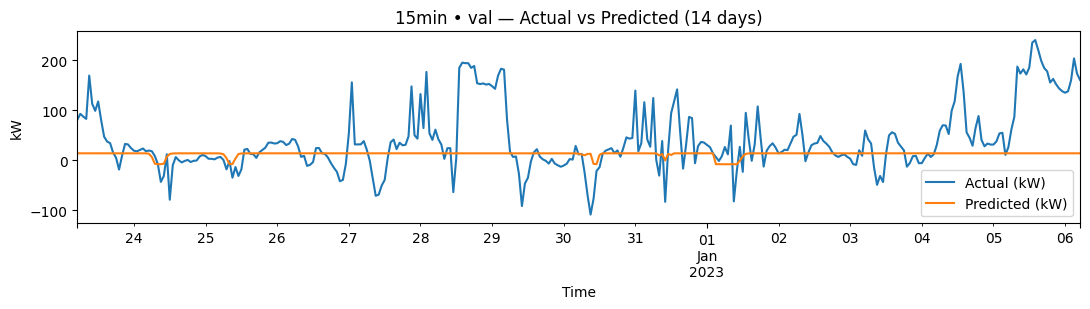

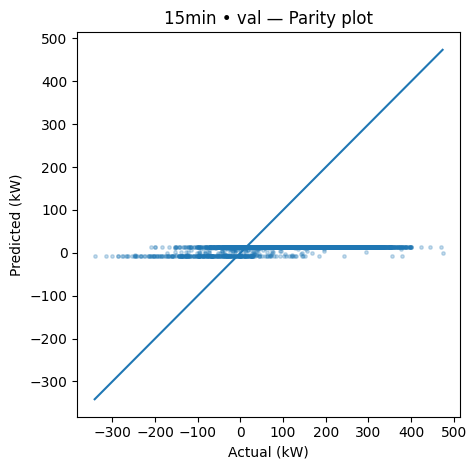

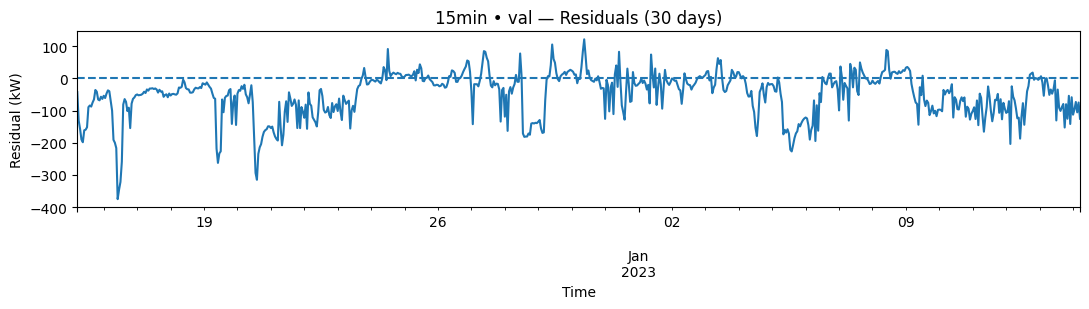

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Predict test:   0%|          | 0/23 [00:00<?, ?it/s]


[TEST] metrics:
  RMSE_kW: 166.3644
  MAE_kW: 139.8136
  MAPE_%: 94.8953
  sMAPE_%: 78.9319
  R2: -0.9885
  Peak10_MAE_kW: 308.6960


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

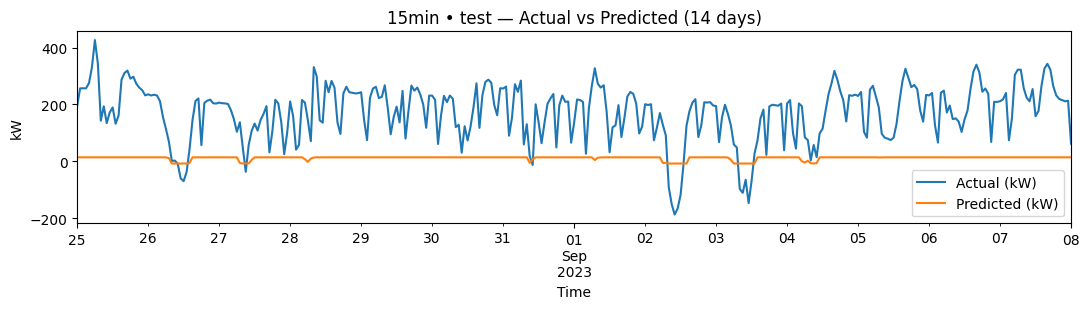

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


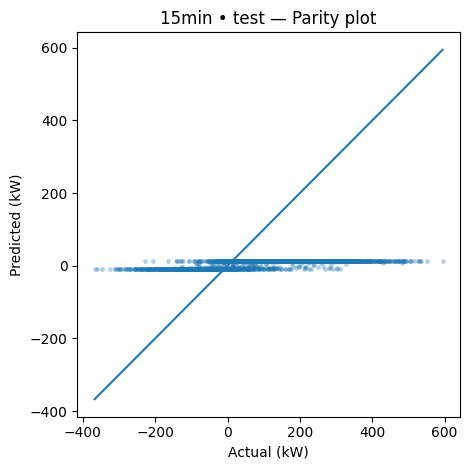

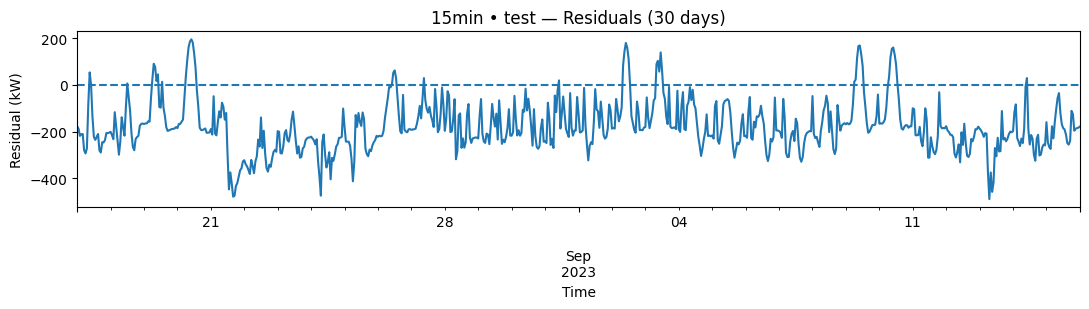

Saved plots → /content/eval_plots/15min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
# ============================================
# Actual vs Predicted (val & test) — clean eval for the trained CNN+LSTM
# ============================================
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# ----- CONFIG -----
FREQ      = "15min"      # "1min" | "15min" | "1h"
CLIENT    = "CAMPUS"
LOOKBACK  = 24           # must match packaging
BASE_FL   = Path("fl_ready")/FREQ/CLIENT
BASE_PREP = Path("prepared")/FREQ
MODEL_DIR = Path("models")
MODEL_PATH = MODEL_DIR/f"cnn_lstm_{FREQ}_{CLIENT}.pt"
OUTDIR    = Path("eval_plots")/FREQ; OUTDIR.mkdir(parents=True, exist_ok=True)
SHOW      = True

# ----- Data -----
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loader(split="val", bs=256, pin=True):
    X = np.load(BASE_FL/f"X_{split}.npy"); y = np.load(BASE_FL/f"y_{split}.npy")
    dl = DataLoader(SequenceDataset(X,y), batch_size=bs, shuffle=False,
                    num_workers=0, pin_memory=pin)
    return dl, X, y

# reconstruct timestamp index for each split
def load_hourly_index():
    df = pd.read_parquet(BASE_PREP/"hourly_table.parquet").sort_index()
    df.index = pd.to_datetime(df.index)
    return df.index, len(df)

def split_bounds(n, train=0.70, val=0.15):
    i_tr = int(n*train); i_va = int(n*(train+val))
    return i_tr, i_va, n

def y_timestamps_for_split(full_index, split_name, lookback=LOOKBACK):
    n = len(full_index)
    i_tr, i_va, i_te = split_bounds(n)
    if split_name == "train":
        start, end = lookback, i_tr
    elif split_name == "val":
        start, end = i_tr + lookback, i_va
    elif split_name == "test":
        start, end = i_va + lookback, n
    else:
        raise ValueError("split must be train|val|test")
    return full_index[start:end]

# ----- Model (must match the training architecture) -----
class ResConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k1=3, k2=5, p1=1, p2=2, dropout=0.15):
        super().__init__()
        self.conv1 = nn.Conv1d(c_in,  c_out, kernel_size=k1, padding=p1)
        self.bn1   = nn.BatchNorm1d(c_out)
        self.conv2 = nn.Conv1d(c_out, c_out, kernel_size=k2, padding=p2)
        self.bn2   = nn.BatchNorm1d(c_out)
        self.act   = nn.GELU()
        self.drop  = nn.Dropout(dropout)
        self.proj  = nn.Conv1d(c_in, c_out, kernel_size=1) if c_in != c_out else nn.Identity()
    def forward(self, x):
        y = self.drop(self.act(self.bn1(self.conv1(x))))
        y = self.drop(self.act(self.bn2(self.conv2(y))))
        return y + self.proj(x)

class CNNLSTMReg(nn.Module):
    # defaults match the training cell (cnn_channels=128, lstm_hidden=160, layers=2, dropout=0.15)
    def __init__(self, n_feat, cnn_channels=128, lstm_hidden=160, lstm_layers=2, dropout=0.15):
        super().__init__()
        self.norm_in = nn.LayerNorm(n_feat)
        self.cnn = ResConvBlock(n_feat, cnn_channels, dropout=dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, num_layers=lstm_layers,
                            dropout=dropout, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden, 96), nn.ReLU(), nn.Dropout(dropout), nn.Linear(96, 1)
        )
    def forward(self, x):                 # x: (B,T,F)
        x = self.norm_in(x)
        x = x.permute(0,2,1)              # (B,F,T)
        x = self.cnn(x)                    # (B,C,T)
        x = x.permute(0,2,1)              # (B,T,C)
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :]).squeeze(-1)

# ----- Metrics (kW) -----
def to_kw(a):
    return a/1000.0 if isinstance(a, (np.ndarray, float, int)) else a/1000.0

@torch.no_grad()
def regression_metrics(y_true_w, y_pred_w):
    y = torch.as_tensor(y_true_w).float().cpu()
    yhat = torch.as_tensor(y_pred_w).float().cpu()
    y_kw, yhat_kw = y/1000.0, yhat/1000.0
    err = yhat_kw - y_kw
    mae  = torch.mean(torch.abs(err)).item()
    rmse = torch.sqrt(torch.mean(err**2)).item()
    mask = (y_kw.abs() >= 0.5)
    if mask.any():
        mape  = (torch.mean(torch.abs((y_kw[mask]-yhat_kw[mask]) / y_kw[mask]))*100).item()
        smape = (torch.mean(torch.abs(y_kw[mask]-yhat_kw[mask]) /
                            (torch.abs(y_kw[mask])+torch.abs(yhat_kw[mask])).clamp_min(1e-6))*100).item()
    else:
        mape = smape = math.nan
    var = torch.var(y_kw, unbiased=False)
    r2 = float(1.0 - torch.mean(err**2)/var) if var > 0 else math.nan
    q90 = torch.quantile(y_kw, 0.90)
    peak = torch.mean(torch.abs(err[y_kw >= q90])).item() if (y_kw >= q90).any() else math.nan
    return {"RMSE_kW": rmse, "MAE_kW": mae, "MAPE_%": mape, "sMAPE_%": smape, "R2": r2, "Peak10_MAE_kW": peak}

# ----- Inference -----
@torch.no_grad()
def predict_split(split):
    dl, X, y = make_loader(split, bs=256, pin=torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(MODEL_PATH, map_location=device)
    n_feat = ckpt.get("n_feat", X.shape[2])
    model = CNNLSTMReg(n_feat=n_feat).to(device)
    model.load_state_dict(ckpt["state_dict"]); model.eval()

    preds = []
    for xb, _ in tqdm(dl, desc=f"Predict {split}", leave=False):
        preds.append(model(xb.to(device)).cpu().numpy())
    y_pred = np.concatenate(preds).astype(np.float32)
    y_true = y.astype(np.float32)

    full_index, _ = load_hourly_index()
    ts = y_timestamps_for_split(full_index, split)
    assert len(ts) == len(y_true), f"timestamp len {len(ts)} != y len {len(y_true)}"
    return ts, y_true, y_pred

# ----- Plotters -----
def _save_and_show(path, show=SHOW, dpi=160):
    plt.tight_layout(); plt.savefig(path, dpi=dpi)
    if show: plt.show()
    plt.close()

def plot_timeseries(ts, y_true_w, y_pred_w, title, outpath, days=14):
    s = pd.Series(y_true_w/1000.0, index=ts, name="Actual (kW)")
    p = pd.Series(y_pred_w/1000.0, index=ts, name="Predicted (kW)")
    df = pd.concat([s, p], axis=1)
    if (df.index.max() - df.index.min()).days > days:
        mid = df.index.min() + (df.index.max() - df.index.min())/2
        df = df.loc[mid - pd.Timedelta(days=days/2) : mid + pd.Timedelta(days=days/2)]
    plt.figure(figsize=(11,3.2))
    df["Actual (kW)"].plot()
    df["Predicted (kW)"].plot()
    plt.legend(); plt.title(title); plt.ylabel("kW"); plt.xlabel("Time")
    _save_and_show(outpath)

def plot_parity(y_true_w, y_pred_w, title, outpath, max_pts=20000):
    y  = (np.asarray(y_true_w).astype(float))/1000.0
    yp = (np.asarray(y_pred_w).astype(float))/1000.0
    if len(y) > max_pts:
        idx = np.random.choice(len(y), max_pts, replace=False); y, yp = y[idx], yp[idx]
    lim = [float(min(y.min(), yp.min())), float(max(y.max(), yp.max()))]
    plt.figure(figsize=(4.8,4.8))
    plt.scatter(y, yp, s=6, alpha=0.25)
    plt.plot(lim, lim)
    plt.title(title); plt.xlabel("Actual (kW)"); plt.ylabel("Predicted (kW)")
    _save_and_show(outpath)

def plot_residuals(ts, y_true_w, y_pred_w, title, outpath, days=30):
    res = (np.asarray(y_pred_w) - np.asarray(y_true_w))/1000.0
    df = pd.Series(res, index=ts, name="Residual (kW)").to_frame()
    if (df.index.max() - df.index.min()).days > days:
        mid = df.index.min() + (df.index.max() - df.index.min())/2
        df = df.loc[mid - pd.Timedelta(days=days/2) : mid + pd.Timedelta(days=days/2)]
    plt.figure(figsize=(11,3.2))
    df["Residual (kW)"].plot()
    plt.axhline(0, linestyle="--")
    plt.title(title); plt.ylabel("Residual (kW)"); plt.xlabel("Time")
    _save_and_show(outpath)

# ----- Run for VAL & TEST -----
for split in ["val", "test"]:
    ts, y_true, y_pred = predict_split(split)
    mets = regression_metrics(y_true, y_pred)
    print(f"\n[{split.upper()}] metrics:")
    for k, v in mets.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) and not math.isnan(v) else f"  {k}: {v}")

    plot_timeseries(ts, y_true, y_pred,
                    title=f"{FREQ} • {split} — Actual vs Predicted (14 days)",
                    outpath=OUTDIR/f"{split}_timeseries_14d.png")
    plot_parity(y_true, y_pred,
                title=f"{FREQ} • {split} — Parity plot",
                outpath=OUTDIR/f"{split}_parity.png")
    plot_residuals(ts, y_true, y_pred,
                   title=f"{FREQ} • {split} — Residuals (30 days)",
                   outpath=OUTDIR/f"{split}_residuals_30d.png")

print("Saved plots →", OUTDIR.resolve())


In [10]:


# ========= Silence everything =========
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "3"

# ========= Model =========
class ResConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k1=3, k2=5, p1=1, p2=2, dropout=0.15):
        super().__init__()
        self.conv1 = nn.Conv1d(c_in, c_out, kernel_size=k1, padding=p1)
        self.bn1 = nn.BatchNorm1d(c_out)
        self.conv2 = nn.Conv1d(c_out, c_out, kernel_size=k2, padding=p2)
        self.bn2 = nn.BatchNorm1d(c_out)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.proj = nn.Conv1d(c_in, c_out, 1) if c_in != c_out else nn.Identity()
    def forward(self, x):
        y = self.drop(self.act(self.bn1(self.conv1(x))))
        y = self.drop(self.act(self.bn2(self.conv2(y))))
        return y + self.proj(x)

class CNNLSTMReg(nn.Module):
    def __init__(self, n_feat, cnn_channels=128, lstm_hidden=160, lstm_layers=2, dropout=0.15):
        super().__init__()
        self.norm_in = nn.LayerNorm(n_feat)
        self.cnn = ResConvBlock(n_feat, cnn_channels, dropout=dropout)
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, lstm_layers, dropout=dropout, batch_first=True)
        self.head = nn.Sequential(nn.Linear(lstm_hidden, 96), nn.ReLU(), nn.Dropout(dropout), nn.Linear(96,1))
    def forward(self, x):
        x = self.norm_in(x)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :]).squeeze(-1)

# Dataset & loader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).unsqueeze(-1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def loaders_from_fl_ready(freq: str, client_id: str, batch=128):
    base = Path("fl_ready") / freq / client_id
    Xtr = np.load(base / "X_train.npy")
    ytr = np.load(base / "y_train.npy")
    Xva = np.load(base / "X_val.npy")
    yva = np.load(base / "y_val.npy")
    dl_tr = DataLoader(SequenceDataset(Xtr, ytr), batch_size=batch, shuffle=True, drop_last=True)
    dl_va = DataLoader(SequenceDataset(Xva, yva), batch_size=batch, shuffle=False)
    return dl_tr, dl_va

# AMP utilities
def make_amp():
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        def autocast(enabled):
            try: return torch.amp.autocast(device_type="cuda", enabled=enabled)
            except TypeError: return torch.amp.autocast(enabled=enabled)
        return torch.amp.GradScaler, autocast
    from torch.cuda import amp as cuda_amp
    def autocast(enabled): return cuda_amp.autocast(enabled=enabled)
    return cuda_amp.GradScaler, autocast
GradScalerCls, autocast_ctx = make_amp()

# Flower client
class CampusClient(fl.client.NumPyClient):
    def __init__(self, model, train_loader, val_loader, device):
        self.model, self.device = model.to(device), device
        self.tr_loader, self.val_loader = train_loader, val_loader
        self.opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.loss_fn = nn.SmoothL1Loss(beta=1.0)
        self.use_amp = (device.type == "cuda")
        self.scaler = GradScalerCls(enabled=self.use_amp)
    def get_parameters(self, config=None):
        return [p.detach().cpu().numpy() for _, p in self.model.state_dict().items()]
    def set_parameters(self, parameters):
        state_dict = {k: torch.tensor(v) for (k, _), v in zip(self.model.state_dict().items(), parameters)}
        self.model.load_state_dict(state_dict, strict=True)
    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        local_epochs = int(config.get("local_epochs", 1))
        for _ in range(local_epochs):
            for xb, yb in self.tr_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                self.opt.zero_grad(set_to_none=True)
                with autocast_ctx(self.use_amp):
                    pred = self.model(xb)
                    loss = self.loss_fn(pred / 1000.0, yb / 1000.0)
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.opt)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.opt)
                self.scaler.update()
        return self.get_parameters({}), len(self.tr_loader.dataset), {}
    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        tot, cnt = 0.0, 0
        with torch.no_grad(), autocast_ctx(self.use_amp):
            for xb, yb in self.val_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                pred = self.model(xb)
                loss = self.loss_fn(pred / 1000.0, yb / 1000.0)
                b = xb.size(0)
                tot += loss.item() * b
                cnt += b
        avg = float(tot / max(cnt, 1))
        return avg, cnt, {"val_loss": avg}

# Networking helpers
def pick_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(("127.0.0.1", 0))
    _, port = s.getsockname()
    s.close()
    return port

def wait_for_port(host, port, timeout=15.0):
    t0 = time.time()
    while time.time() - t0 < timeout:
        try:
            with socket.create_connection((host, port), timeout=1.0): return True
        except OSError:
            time.sleep(0.1)
    return False

# Server process and client thread

def server_process(addr, rounds, num_clients, Xva, yva, metrics_q):
    import logging
    logging.getLogger("flwr").setLevel(logging.ERROR)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_feat = Xva.shape[-1]
    def build_model_from_params(nd_arrays):
        model = CNNLSTMReg(n_feat).to(device)
        keys = list(model.state_dict().keys())
        state_dict = {k: torch.tensor(v) for k, v in zip(keys, nd_arrays)}
        model.load_state_dict(state_dict, strict=True)
        return model
    def evaluation_fn(server_round, params, config):
        if isinstance(params, list): params = ndarrays_to_parameters(params)
        nds = parameters_to_ndarrays(params)
        model = build_model_from_params(nds)
        model.eval()
        with torch.no_grad():
            xb = torch.from_numpy(Xva).float().to(device)
            yb = torch.from_numpy(yva).float().to(device)
            pred = model(xb)
            loss = torch.mean(torch.abs(pred/1000.0 - yb/1000.0)).item()
            err = pred - yb
            ss_res = torch.sum(err**2)
            ss_tot = torch.sum((yb - torch.mean(yb))**2) + 1e-9
            r2 = (1.0 - ss_res/ss_tot).item()
        if server_round == rounds:
            metrics_q.put({"loss": float(loss), "accuracy": float(r2)})
        return float(loss), {"r2": float(r2)}

    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0, fraction_evaluate=1.0,
        min_fit_clients=num_clients, min_evaluate_clients=num_clients, min_available_clients=num_clients,
        on_fit_config_fn=lambda rnd: {"local_epochs": 1},
        evaluate_fn=evaluation_fn,
    )
    fl.server.start_server(server_address=addr, config=fl.server.ServerConfig(num_rounds=rounds), strategy=strategy)

def client_thread(addr, freq, client_id):
    tr_loader, va_loader = loaders_from_fl_ready(freq, client_id, batch=128)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_feat = tr_loader.dataset.X.shape[-1]
    model = CNNLSTMReg(n_feat)
    numpy_client = CampusClient(model, tr_loader, va_loader, device)
    # Retry connect loop to avoid clients crashing if server is not ready
    while True:
        try:
            fl.client.start_client(server_address=addr, client=numpy_client.to_client())
            break
        except Exception:
            time.sleep(1)

if __name__ == "__main__":
    NUM_CLIENTS = 2
    ROUNDS = 3
    DATA_FREQ = "15min"
    CLIENT_ID = "CAMPUS"
    DATA_DIR = Path("fl_ready") / DATA_FREQ / CLIENT_ID
    Xva = np.load(DATA_DIR / "X_val.npy")
    yva = np.load(DATA_DIR / "y_val.npy")
    port = pick_free_port()
    server_addr = f"127.0.0.1:{port}"
    metrics_q = mp.Queue()
    srv = mp.Process(target=server_process, args=(server_addr, ROUNDS, NUM_CLIENTS, Xva, yva, metrics_q), daemon=True)
    srv.start()
    assert wait_for_port("127.0.0.1", port, timeout=15.0), "Server failed to start"
    clients = []
    for _ in range(NUM_CLIENTS):
        t = threading.Thread(target=client_thread, args=(server_addr, DATA_FREQ, CLIENT_ID), daemon=True)
        t.start()
        clients.append(t)
    for t in clients:
        t.join()
    srv.join()
    final = metrics_q.get(timeout=10)
    print(f"accuracy (R2): {abs(final['accuracy']):.4f}")
    print(f"loss: {final['loss']:.6f}")
    print(" Federated run completed cleanly.")


	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.


accuracy (R2): 1.1452
loss: 127.355492
 Federated run completed cleanly.
